# VibeShare Model Analysis

This notebook provides a comparative analysis of various AI models based on their responses to specific prompts. It evaluates success rates, response characteristics, and the mention of specific AI frameworks, with a particular focus on the Agent Development Kit (ADK).

In [1]:
import json
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from vibeshare.src.data_models import FRAMEWORKS_TO_DETECT

# Set pandas display options for better readability in the detailed responses section
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Load data from the results JSON file
results_path = 'vibeshare_results.json'

try:
    with open(results_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} results from {results_path}.")
except FileNotFoundError:
    print("vibeshare_results.json not found. Please run analyze_vibeshare.py first.")
    data = []

Loaded 672 results from vibeshare_results.json.


## Framework Master List
The following frameworks are pre-vetted and actively searched for within model responses. This list includes major orchestration libraries and provider-specific SDKs.

In [2]:
print("Master list of frameworks monitored:")
for i, framework in enumerate(sorted(FRAMEWORKS_TO_DETECT), 1):
    print(f"{i:2}. {framework}")

Master list of frameworks monitored:
 1. Auto-GPT
 2. Devin AI
 3. OpenHands
 4. adk
 5. agent development kit
 6. agentkit
 7. autogen
 8. autogpt
 9. controlflow
10. crewai
11. dialogflow
12. gemini api
13. generative ai python sdk
14. genkit
15. google cloud vertex ai sdk
16. google-cloud-aiplatform
17. google-generativeai
18. haystack
19. jason
20. langchain
21. langchain4j
22. langgraph
23. llamaindex
24. manychat
25. microsoft copilot studio
26. openai api
27. openai assistants
28. openai sdk
29. phidata
30. pydantic ai
31. replit
32. semantic kernel
33. smolagents
34. spring ai
35. swarm
36. vertex ai
37. voiceflow


In [3]:
if data:
    df = pd.DataFrame(data)
    df = df[df['success'] == True]
    # Pre-calculate response length and filter for overview
    df['response_length'] = df['response'].apply(lambda x: len(x) if x is not None else 0)
    
    # display(df.head())

## Success Rate by Model
This chart shows the percentage of prompts that resulted in a successful API response for each model. Failures typically indicate authentication issues, quota limits, or model unavailability.

In [4]:
if not df.empty:
    success_counts = df.groupby('model_name')['success'].mean().reset_index()
    success_counts.rename(columns={'success': 'success_rate'}, inplace=True)
    
    display(HTML("<h3>Success Rate by Model</h3>"))
    display(success_counts.sort_values('success_rate', ascending=False).reset_index(drop=True))

,model_name,success_rate
0,anthropic/claude-opus-4-5,1.0
1,anthropic/claude-sonnet-4-5,1.0
2,gemini-cli-podman/adk-python,1.0
3,gemini-cli-podman/base,1.0
4,gemini-cli/adk-docs-ext-llms,1.0
5,gemini-cli/adk-docs-ext-llms-full,1.0
6,gemini-cli/adk-docs-ext-starter,1.0
7,gemini/gemini-2.5-flash,1.0
8,gemini/gemini-2.5-flash-lite,1.0
9,gemini/gemini-2.5-pro,1.0


## Response Length Distribution
Analyzes the verbosity of successful responses. Models with higher median lengths may provide more detailed explanations or extensive code samples.

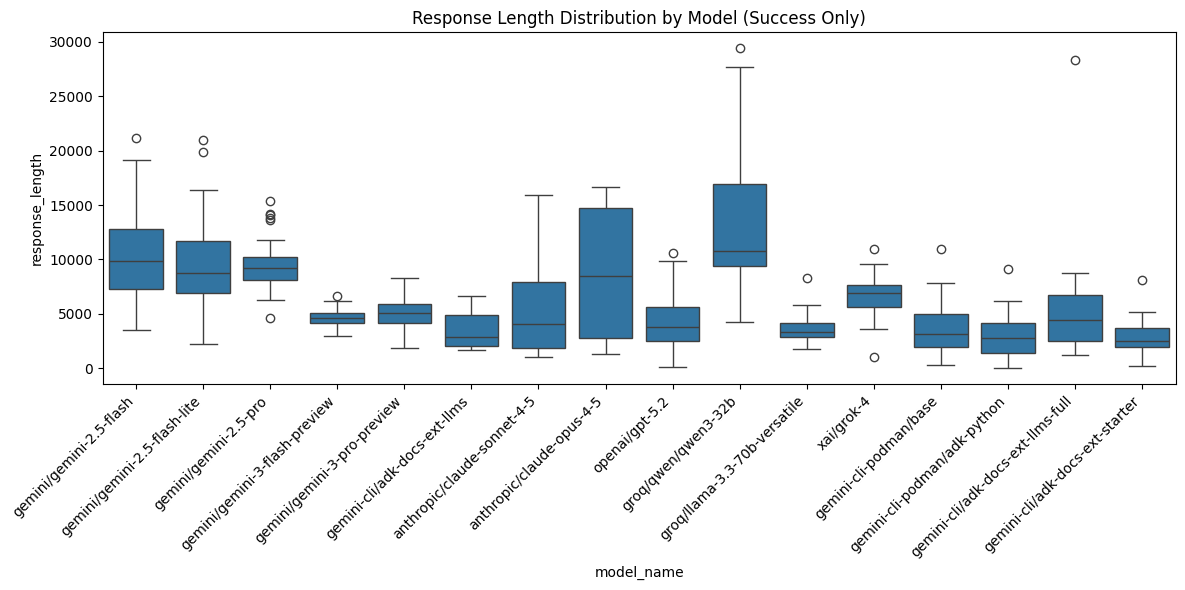

In [5]:
if not df.empty:
    df_success = df[df['success'] == True]
    if not df_success.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_success, x="model_name", y="response_length")
        plt.title("Response Length Distribution by Model (Success Only)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No successful runs to visualize response length.")

## ADK Mentions
Specifically tracks how many successful responses mentioned the Agent Development Kit (ADK) or its variants. This is a key metric for awareness analysis.

In [6]:
if not df.empty:
    if 'was_adk_mentioned' in df.columns:
        df_success = df[df['success'] == True]
        adk_ratio = df_success.groupby('model_name')['was_adk_mentioned'].mean().reset_index()
        adk_ratio.rename(columns={'was_adk_mentioned': 'mention_ratio'}, inplace=True)
        
        display(HTML("<h3>Ratio of Responses Mentioning ADK by Model</h3>"))
        display(adk_ratio.sort_values('mention_ratio', ascending=False).reset_index(drop=True))

,model_name,mention_ratio
0,gemini-cli-podman/adk-python,0.666667
1,anthropic/claude-opus-4-5,0.238095
2,openai/gpt-5.2,0.238095
3,gemini-cli/adk-docs-ext-llms,0.111111
4,anthropic/claude-sonnet-4-5,0.000000
5,gemini-cli-podman/base,0.000000
6,gemini-cli/adk-docs-ext-llms-full,0.000000
7,gemini-cli/adk-docs-ext-starter,0.000000
8,gemini/gemini-2.5-flash,0.000000
9,gemini/gemini-2.5-flash-lite,0.000000


## AI Framework Mentions by Model
A broader view of all detected frameworks across successful responses. This reveals which orchestration libraries are currently favored or most prominent in model training data.

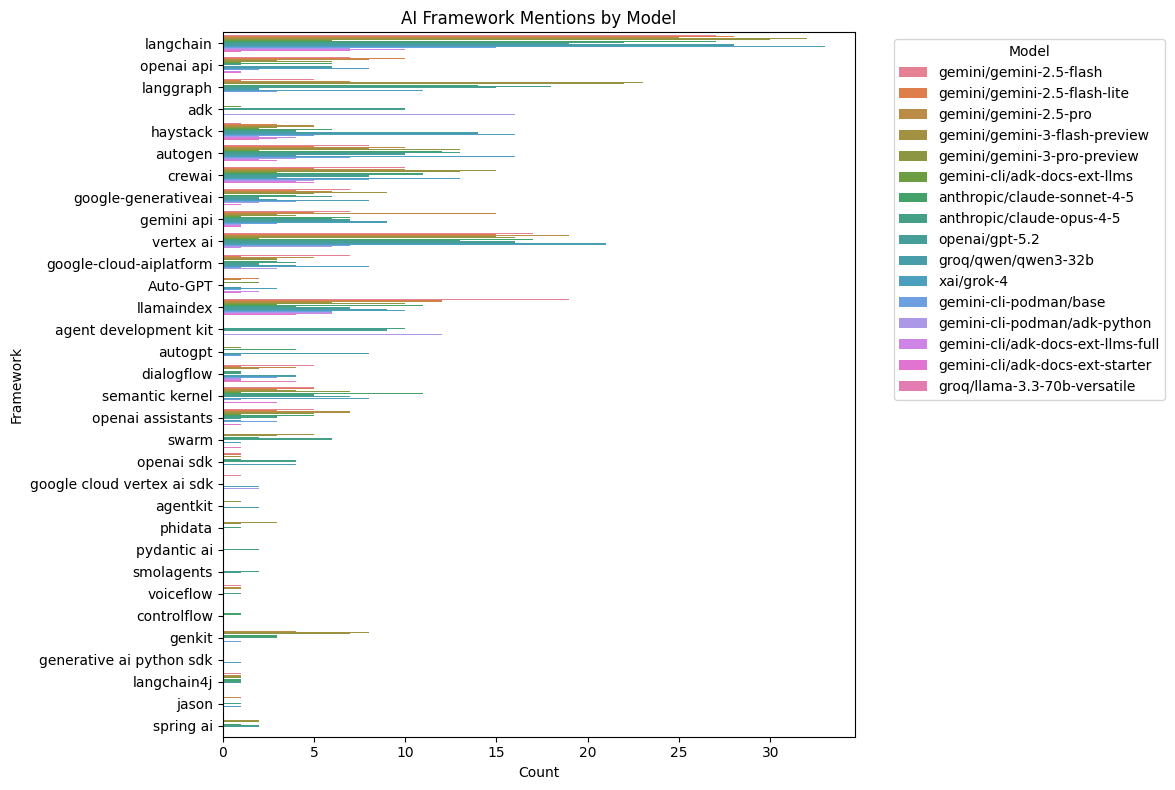

model_name,anthropic/claude-opus-4-5,anthropic/claude-sonnet-4-5,gemini-cli-podman/adk-python,gemini-cli-podman/base,gemini-cli/adk-docs-ext-llms,gemini-cli/adk-docs-ext-llms-full,gemini-cli/adk-docs-ext-starter,gemini/gemini-2.5-flash,gemini/gemini-2.5-flash-lite,gemini/gemini-2.5-pro,gemini/gemini-3-flash-preview,gemini/gemini-3-pro-preview,groq/llama-3.3-70b-versatile,groq/qwen/qwen3-32b,openai/gpt-5.2,xai/grok-4,Total
mentioned_frameworks,,,,,,,,,,,,,,,,,
langchain,22,27,7,15,6,10,7,27,28,25,32,30,1,28,19,33,317
vertex ai,13,17,6,7,2,1,0,17,15,19,15,16,0,21,16,21,186
llamaindex,4,11,6,6,3,6,4,19,12,12,6,10,0,9,7,10,125
crewai,11,11,5,8,3,4,5,10,5,10,15,13,0,3,8,13,124
langgraph,18,14,0,3,0,0,0,5,1,7,23,22,0,2,15,11,121
autogen,13,12,4,7,2,2,3,8,5,10,8,13,0,4,10,16,117
gemini api,6,7,1,3,1,1,1,7,5,15,3,4,0,9,7,9,79
haystack,4,6,2,5,2,4,3,1,3,5,5,3,2,14,4,16,79
google-generativeai,6,4,2,4,0,0,1,7,4,6,9,5,0,3,2,8,61


In [7]:
if not df.empty and 'mentioned_frameworks' in df.columns:
    df_exploded = df.explode('mentioned_frameworks')
    df_frameworks = df_exploded.dropna(subset=['mentioned_frameworks'])
    
    if not df_frameworks.empty:
        plt.figure(figsize=(12, 8))
        sns.countplot(data=df_frameworks, y='mentioned_frameworks', hue='model_name')
        plt.title('AI Framework Mentions by Model')
        plt.xlabel('Count')
        plt.ylabel('Framework')
        plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Summary Table
        framework_counts = df_frameworks.groupby(['mentioned_frameworks', 'model_name']).size().unstack(fill_value=0)
        # Add a total column for easier analysis
        framework_counts['Total'] = framework_counts.sum(axis=1)
        display(HTML("<h3>AI Framework Mentions Summary Table</h3>"))
        display(framework_counts.sort_values('Total', ascending=False))

## Top 10 Frameworks Response Analysis
Below are the specific responses from each model to the prompt: "List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each."

In [8]:
target_prompt = "List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each."
if not df.empty:
    target_responses = df[df['prompt'] == target_prompt]
    if not target_responses.empty:
        for index, row in target_responses.iterrows():
            display(HTML(f"<h3>Model: {row['model_name']}</h3>"))
            print(row['response'])
            display(HTML("<hr>"))
    else:
        print("No responses found for the target prompt.")

The landscape of generative AI is evolving rapidly, and by 2025, the focus will increasingly be on building sophisticated, autonomous, and robust AI agents. These frameworks facilitate everything from orchestrating LLM calls and managing memory to enabling tool use and multi-agent collaboration.

Here are the top 10 Python frameworks for building generative AI agents in 2025:

1.  **LangChain**
    *   **Description:** Still a dominant force, LangChain will continue to be a go-to framework for chaining together large language models (LLMs) with other data sources and tools. Its modular design allows developers to build complex agents that can reason, observe, plan, and act. Expect continued improvements in stability, performance, and integrations for more advanced agentic capabilities, including robust memory management and sophisticated planning modules.
    *   **Key for Agents:** Orchestration, memory, tool integration, agentic loops, prompt templating.

2.  **LlamaIndex (formerly G

It's exciting to think about generative AI agents in 2025! While it's impossible to predict the exact landscape with absolute certainty, based on current trends and the rapid evolution of the field, here's a list of the top 10 Python frameworks that are highly likely to be instrumental in building generative AI agents by 2025, along with brief descriptions:

## Top 10 Python Frameworks for Building Generative AI Agents in 2025

1.  **LangChain:**
    *   **Description:** LangChain is a leading framework designed for developing applications powered by language models. It provides a structured way to chain together different components like LLMs, prompt templates, vector databases, and agents, enabling complex reasoning, memory, and tool integration. It's a cornerstone for building agents that can interact with external data and perform multi-step tasks.

2.  **LlamaIndex (formerly GPT Index):**
    *   **Description:** LlamaIndex is a data framework for LLM applications. Its primary foc

Of course. Here are the top 10 Python frameworks for building generative AI agents, with a projection for their relevance and popularity in 2025.

The landscape is rapidly evolving from simple LLM wrappers to sophisticated frameworks for creating autonomous agents that can reason, plan, and use tools. The key trend for 2025 is the move towards **multi-agent systems** and more **reliable, production-grade** agentic workflows.

---

### 1. LangChain
**The Orchestration Powerhouse**

LangChain is the most established and comprehensive framework for developing applications powered by language models. It provides a modular set of components and "chains" to connect LLMs with external data sources, APIs, and other tools. For agents, it provides standard interfaces for tools, memory, and reasoning logic (like ReAct and Plan-and-Solve), making it a powerful, all-in-one toolkit.

*   **Best for:** General-purpose agent development, rapid prototyping, and building complex, chained workflows. Its 

The landscape of AI agent development has shifted from simple "wrappers" to complex, multi-agent systems that can reason, use tools, and maintain state.

Here are the top 10 Python frameworks for building generative AI agents in 2025:

### 1. LangGraph (by LangChain)
LangGraph has become the industry standard for building complex, stateful agents. Unlike traditional linear chains, it allows for "cycles," enabling agents to loop back, reflect on their work, and self-correct. It is ideal for custom cognitive architectures where you need fine-grained control over the agent's logic.

### 2. CrewAI
CrewAI focuses on "Role-Based" multi-agent orchestration. It allows you to create a "crew" of agents (e.g., a Researcher, a Writer, and a Manager) that work together to complete tasks. It is highly popular because of its intuitive design and its ability to manage "process" flows (sequential, hierarchical, or consensual) between agents.

### 3. PydanticAI (by Pydantic)
The newest heavyweight on th

Predicting the tech landscape for 2025 requires looking at the current momentum of AI development. The field is moving away from simple "chatbots" toward **autonomous agents**—AI that can plan, use tools, and execute complex workflows.

Here are the top 10 Python frameworks likely to dominate the generative AI agent landscape in 2025.

### 1. LangChain
**The Industry Standard for Chains**
By 2025, LangChain remains the "Swiss Army Knife" of LLM development. It excels at chaining together different components (prompts, models, and output parsers). Its ecosystem has matured to support complex cognitive architectures, making it the go-to for developers who want granular control over memory, retrieval-augmented generation (RAG), and tool usage.

### 2. AutoGen (Microsoft)
**The Leader in Multi-Agent Conversation**
AutoGen focuses on multi-agent collaboration. Instead of a single AI trying to do everything, AutoGen allows you to spin up multiple "specialist" agents (e.g., a coder, a reviewe

Here are 10 Python frameworks for building generative AI agents that are highly relevant in 2025:

1.  **LangChain:** A popular framework for developing applications powered by large language models (LLMs). It provides tools for chaining LLM calls, managing prompts, and integrating with external data sources and agents.
2.  **LlamaIndex (formerly GPIndex):** Focuses on providing a central interface to connect your custom knowledge bases with LLMs. It's excellent for building retrieval-augmented generation (RAG) applications and agents that need to interact with specific data.
3.  **Haystack:** An open-source framework for building end-to-end LLM applications. It offers modular components for tasks like RAG, question answering, and agentic workflows, with a strong emphasis on production readiness.
4.  **AutoGen (Microsoft):** A framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. It supports complex multi-agen

1.  **LangChain:** A widely adopted framework for developing applications powered by language models. It simplifies chaining together different components like LLMs, prompt management, memory, and various tools, making it easy to build complex generative AI agents.
2.  **LlamaIndex (formerly GPIndex):** Specializes in data framework for LLM applications. It provides tools for ingesting, structuring, and accessing private or domain-specific data to be used with LLMs, making it excellent for RAG (Retrieval Augmented Generation) agents.
3.  **Haystack (deepset):** An open-source framework for building end-to-end NLP applications, including generative QA and search systems. It's highly modular and allows for easy integration of different components like LLMs, document stores, and retrievers.
4.  **AutoGen (Microsoft Research):** A framework that enables the development of LLM applications by orchestrating multiple agents that can converse with each other to solve tasks. It supports complex

Here are 10 Python frameworks for building generative AI agents, popular in 2025:

1.  **LangChain**: A framework designed to simplify the creation of applications powered by large language models. It provides tools for chaining together different LLM components, managing memory, and interacting with external data sources and APIs.
2.  **LlamaIndex**: Focuses on making it easy to build LLM applications over custom data. It provides tools for data ingestion, indexing, and querying, allowing LLMs to effectively reason over private or domain-specific information.
3.  **Haystack**: An open-source NLP framework that helps you build custom search and QA systems with LLMs. It's designed for production-ready applications, offering components for document retrieval, ranking, and answer generation.
4.  **AutoGen**: A framework from Microsoft Research that enables the development of LLM applications by orchestrating multiple agents. These agents can converse with each other to solve tasks, facili

Here are the top 10 Python frameworks for building generative AI agents in 2025:

1.  **LangChain:** A comprehensive framework for developing applications powered by language models. It provides modules for various components, including model I/O, retrieval, agents, and chains, making it easy to build complex LLM applications.
2.  **LlamaIndex (formerly GPIndex):** Specializes in data framework for LLM applications, offering tools to ingest, structure, and access private or domain-specific data for use with LLMs. It excels at making data ready for prompt engineering.
3.  **Haystack:** An open-source NLP framework that helps you build custom search, question answering, and other AI applications. It's particularly strong for applications requiring robust document retrieval and answer extraction.
4.  **AutoGen (Microsoft):** A framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. It focuses on multi-agent convers

# Top 10 Python Frameworks for Building Generative AI Agents in 2025

## 1. **LangChain**
A comprehensive framework for developing applications powered by language models. Provides chains, agents, and memory components for building complex LLM workflows with tool integration and retrieval-augmented generation (RAG).

## 2. **LlamaIndex**
Specialized in data ingestion and indexing for LLM applications. Excels at connecting custom data sources to language models, making it ideal for building knowledge-based AI agents with efficient document retrieval.

## 3. **AutoGPT/AutoGen (Microsoft)**
Framework for creating autonomous AI agents that can break down tasks, use tools, and collaborate with other agents. Supports multi-agent conversations and complex problem-solving workflows.

## 4. **CrewAI**
Orchestrates role-playing autonomous AI agents that work together as a crew. Emphasizes multi-agent collaboration with defined roles, goals, and backstories for complex task execution.

## 5. **Ha

# Top 10 Python Frameworks for Building Generative AI Agents in 2025

## 1. **LangChain**
The most established framework for building LLM-powered applications. Provides modular components for chains, memory, tools, and retrieval-augmented generation (RAG). Excellent for complex multi-step reasoning workflows.

## 2. **LangGraph**
Built on LangChain, specifically designed for stateful, multi-actor agent systems. Uses a graph-based architecture enabling cycles, branching, and persistent state management for sophisticated agent orchestration.

## 3. **AutoGen (Microsoft)**
Focuses on multi-agent conversations where multiple AI agents collaborate to solve tasks. Supports human-in-the-loop patterns and is particularly strong for code generation and execution workflows.

## 4. **CrewAI**
Role-based multi-agent framework where you define agents with specific roles, goals, and backstories. Agents collaborate naturally, making it intuitive for building team-like AI systems.

## 5. **LlamaIndex*

1) **LangChain**  
   Widely used toolkit for building LLM-powered applications and agents. Provides abstractions for tools/functions, retrieval (RAG), memory, agent policies, and integrations with many model and vector DB providers.

2) **LangGraph (by LangChain)**  
   Graph/state-machine framework for *controllable*, multi-step agents. Lets you define agent workflows as nodes/edges with persistence, retries, branching, and human-in-the-loop checkpoints—useful for reliable production agents.

3) **LlamaIndex**  
   Data framework focused on connecting LLM agents to external knowledge. Strong support for ingestion pipelines, indexing, retrieval, structured data connectors, and “agentic” patterns that ground actions in your data.

4) **OpenAI Agents SDK (Python)**  
   SDK for building tool-using agents around OpenAI models, emphasizing function calling/tools, structured outputs, and orchestration patterns. Commonly used when you want a straightforward path to production with OpenAI-ba

<think>
Okay, so the user is asking for the top 10 Python frameworks for building generative AI agents in 2025 and wants a brief description of each. Let me start by recalling what generative AI agents typically do. They generate text, images, or other content based on input. Now, Python frameworks that support this kind of work would likely include things like machine learning libraries, deep learning frameworks, and agent-based modeling tools.

First, I should think about existing popular frameworks. Tensorflow and PyTorch are definitely at the top of the list. They are essential for building and training neural networks, which are the backbone of generative models. But maybe there are others specifically tailored for agents. I recall that LangChain is a newer framework focused on creating applications with language models. Similarly, Hugging Face's Transformers is widely used for pre-trained models like GPT or BERT. 

Then there's JAX, which is becoming popular for high-performance 

Here are the top 10 Python frameworks for building generative AI agents in 2025, along with a brief description of each:

1. **TensorFlow**: An open-source framework developed by Google, TensorFlow provides a wide range of tools and libraries for building generative models, including Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).
2. **PyTorch**: Another popular open-source framework, PyTorch provides a dynamic computation graph and automatic differentiation, making it well-suited for building and training generative models.
3. **Keras**: A high-level neural networks API, Keras provides an easy-to-use interface for building and training generative models, including GANs and VAEs, on top of TensorFlow or PyTorch.
4. **Transformers**: Developed by Hugging Face, Transformers provides a wide range of pre-trained language models and a simple interface for building and fine-tuning generative text models, including language translation and text generation.
5. **Sta

Below is a list of the top 10 Python frameworks for building generative AI agents as of 2025, based on current trends, adoption rates, and advancements in the field. Generative AI agents typically involve systems that can create content (e.g., text, images, code) while performing autonomous tasks like reasoning, decision-making, or multi-agent collaboration. This ranking is subjective and draws from popularity metrics (e.g., GitHub stars, community usage, and enterprise adoption) projected forward from 2023-2024 data. I've prioritized frameworks that are open-source, versatile, and specifically geared toward agentic workflows with generative models.

For each, I've included a brief description, key features, and common use cases.

### 1. **LangChain**
   - **Description**: A comprehensive framework for building applications with large language models (LLMs), enabling the creation of generative agents that chain together prompts, tools, and memory for complex tasks.
   - **Key Features*

## Detailed Responses by Model and Category
The table below shows full interaction details. Prompts and responses are truncated to 500 characters for concise viewing while maintaining a structured layout.

In [9]:
if not df.empty:
    df_sorted = df.sort_values(by=['model_name', 'category'])
    grouped = df_sorted.groupby(['model_name', 'category'])
    
    for (model, category), group in grouped:
        display(HTML(f"<h3>Model: {model} | Category: {category}</h3>"))
        
        cols = ['prompt', 'response', 'was_adk_mentioned', 'mentioned_frameworks', 'success', 'error_message']
        cols = [c for c in cols if c in group.columns]
        
        display_df = group[cols].copy()
        for col in ['prompt', 'response']:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(lambda x: (str(x)[:500] + '...') if x and len(str(x)) > 500 else x)

        # Apply style to render newlines in text columns
        text_cols = [c for c in ['prompt', 'response'] if c in display_df.columns]
        if text_cols:
            styler = display_df.style.set_properties(subset=text_cols, **{'white-space': 'pre-wrap', 'text-align': 'left'})
            display(styler)
        else:
            display(display_df)

        display(HTML("<hr>"))

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
11,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","# AI Customer Support Agent for E-Commerce I'll build a comprehensive customer support agent using **LangGraph** - a modern framework that excels at tool-calling, state management, and orchestration for complex agent workflows. ## Project Structure ``` ecommerce_support_agent/ ├── agent/ │ ├── __init__.py │ ├── graph.py # Main agent graph │ ├── state.py # State definitions │ ├── nodes.py # Processing nodes │ ├── tools.py # Tool definitions │ ...",False,"['langchain', 'langgraph']",True,nan
27,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"# AI Stock Trading Agent with News Sentiment Analysis This comprehensive Python-based AI agent monitors stock prices, analyzes news sentiment using Google's Gemini models, and executes simulated trades based on the analysis. ## Project Structure ``` stock_trading_agent/ ├── config/ │ └── settings.py ├── agents/ │ ├── __init__.py │ ├── base_agent.py │ ├── sentiment_agent.py │ ├── trading_agent.py │ └── orchestrator.py ├── services/ │ ├── __init__.py │ ├── stock_service.py │ ├...",False,"['google-generativeai', 'gemini api']",True,nan
43,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"# Smart Home Energy Optimization Agent I'll design a comprehensive AI agent system using a high-level agentic framework. This solution uses **LangGraph** for orchestration with a modular, production-ready architecture. ## System Architecture Overview ``` ┌─────────────────────────────────────────────────────────────────────────────┐ │ SMART HOME ENERGY AGENT │ ├─────────────────────────────────────────────────────────────────────────────┤ │ ...",False,['langgraph'],True,nan
59,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,# Language Learning Tutor AI Agent I'll build a conversational language tutor using **LangChain** with a custom agent framework that handles conversation history and persona management natively. ## Project Structure ``` language_tutor/ ├── main.py ├── agent/ │ ├── __init__.py │ ├── tutor_agent.py │ ├── persona.py │ └── memory.py ├── tools/ │ ├── __init__.py │ ├── vocabulary.py │ ├── grammar.py │ ├── exercises.py │ └── pronunciation.py ├── models/ │ ├── __init__.py │ └── ...,False,['langchain'],True,nan
75,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"# AI Email Triage Agent I'll build an email triage agent using **LangGraph**, a library specifically designed for building agentic workflows with cycles, state management, and human-in-the-loop capabilities. ## Project Structure ``` email_triage_agent/ ├── pyproject.toml ├── .env.example ├── src/ │ ├── __init__.py │ ├── agent.py # Main agent graph │ ├── state.py # State definitions │ ├── nodes.py # Agent nodes/actions │ ├── tools.py # Email tools ...",False,"['langchain', 'langgraph']",True,nan
91,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,# Multi-Agent System: Research & Blog Writing Pipeline ## Framework Choice: **CrewAI** I chose **CrewAI** for the following reasons: 1. **Role-based agent design** - Perfect for specialized tasks like research and writing 2. **Built-in collaboration** - Agents can share context and hand off work seamlessly 3. **Task dependencies** - Easy to chain tasks where out

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
123,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","# Multi-Agent Framework Comparison: LangChain, AutoGen & Modern Alternatives ## Executive Summary The multi-agent landscape has evolved rapidly. While LangChain and AutoGen pioneered the space, newer frameworks from major AI providers offer more streamlined approaches with native tool integration. --- ## 1. LangChain / LangGraph ### Architecture ```python # LangGraph Multi-Agent Example from langgraph.graph import StateGraph, MessagesState from langgraph.prebuilt import create_react_agent f...",False,"['langgraph', 'swarm', 'vertex ai']",True,nan
139,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"# CrewAI Agent Delegation and Orchestration: A Deep Dive ## Core Architecture Comparison ### CrewAI's Approach CrewAI uses a **role-based hierarchical model** where agents are treated as specialized team members with distinct responsibilities. ```python from crewai import Agent, Task, Crew, Process # Define specialized agents with clear roles researcher = Agent( role=""Senior Research Analyst"", goal=""Uncover cutting-edge developments in AI"", backstory=""""""You work at a leading tec...",False,"['langgraph', 'autogen', 'vertex ai']",True,nan
155,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","# Top 5 Python Libraries for Building Autonomous AI Agents in 2025 ## 1. **LangGraph** (LangChain Ecosystem) **Type:** Community/Open Source ```python from langgraph.graph import StateGraph, END from typing import TypedDict, Annotated import operator class AgentState(TypedDict): messages: Annotated[list, operator.add] next_action: str def reasoning_node(state: AgentState) -> dict: # Agent reasoning logic return {""messages"": [""Analyzed the problem""], ""next_action"": ""execute""} ...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'swarm', 'openai sdk']",True,nan
171,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"# Top 10 Python Frameworks for Building Generative AI Agents in 2025 ## 1. **LangChain** The most established framework for building LLM-powered applications. Provides modular components for chains, memory, tools, and retrieval-augmented generation (RAG). Excellent for complex multi-step reasoning workflows. ## 2. **LangGraph** Built on LangChain, specifically designed for stateful, multi-actor agent systems. Uses a graph-based architecture enabling cycles, branching, and persistent state mana...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'openai assistants']",True,nan
187,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"# Top 15 Python Libraries for LLM Orchestration and Agent Development ## Overview Here's a comprehensive guide to the leading Python libraries for building LLM-powered applications and autonomous agents. --- ## 1. **LangChain** The most popular framework for building LLM applications with composable components. ```python from langchain.chat_models import ChatOpenAI from langchain.agents import create_react_agent, AgentExecutor from langchain.tools import Tool from langchain import hub # I...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'pydantic ai']",True,nan
203,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","# Top 20 Tools and Frameworks for Building AI Agents in Python ## Ranking Methodology Rankings based on: **Ecosystem maturity** | **Community adoption** | **Feature completeness**

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
299,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","# Key Benefits of Google's Recommended Python SDKs for AI Agents ## Overview Google provides several official SDKs for building AI agents, with the **Google Gen AI SDK** being the primary recommendation for new projects. Here's a comprehensive comparison with third-party frameworks. --- ## 1. Native Integration & Optimization ```python # Google Gen AI SDK - Direct, optimized access from google import genai client = genai.Client(api_key=""YOUR_API_KEY"") # Native streaming with optimal perfo...",True,"['langchain', 'adk', 'agent development kit']",True,nan
315,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","# Google's Agent Development Kit (ADK) Yes, Google provides **Agent Development Kit (ADK)** - a Python framework specifically designed for building autonomous agents. ## Key Characteristics - **Purpose-built for agents**: Goes beyond basic LLM API calls to support autonomous, multi-step agent workflows - **Multi-agent support**: Enables building systems with multiple cooperating agents - **Tool integration**: Built-in support for defining and using tools/functions - **Orchestration**: Handles...",True,"['adk', 'agent development kit', 'google-generativeai']",True,nan
331,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"# Google SDKs for Agentic Workflows with Tool Use ## Best Options for Tool Use & Long-Context Reasoning ### 1. **Gemini API (via Google AI SDK)** - Most Direct Option ```python # google-generativeai package import google.generativeai as genai genai.configure(api_key=""YOUR_API_KEY"") # Define tools/functions tools = [{ ""function_declarations"": [{ ""name"": ""get_weather"", ""description"": ""Get weather for a location"", ""parameters"": { ""type"": ""object"", ...",True,"['langchain', 'adk', 'agent development kit', 'vertex ai', 'google-generativeai', 'gemini api', 'google-cloud-aiplatform']",True,nan
347,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"# Building a Simple Agent with Google's Agent Development Kit (ADK) Google's newest and preferred framework for agent development is the **Agent Development Kit (ADK)**, released in 2025. Here's how to build a simple agent: ## Installation ```bash pip install google-adk ``` ## Simple Agent Example ```python """"""Simple agent using Google's Agent Development Kit (ADK)."""""" from google.adk.agents import Agent from google.adk.tools import tool # Define custom tools for the agent @tool def get_w...",True,"['adk', 'agent development kit']",True,nan
363,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"# Vertex AI Agent Builder vs. Google ADK (Agent Development Kit) ## Overview Google now offers two distinct approaches for building AI agents: | Aspect | Vertex AI Agent Builder | Agent Development Kit (ADK) | |--------|------------------------|----------------------------| | **Type** | No-code/low-code platform | Python framework | | **Released** | 2023 (evolved from Dialogflow CX) | March 2025 | | **Target User** | Business users, rapid prototyping | Developers, researchers | | **Control Le...",True,"['adk', 'agent development kit', 'dialogflow']",True,nan
379,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","# Google's Newest Gen AI SDK: **Google Gen AI SDK** (formerly ADK/Genkit) As of my knowledge cutoff (early 2025), Google has been consolidating its gen

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
539,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"# Best TypeScript/JavaScript Frameworks for AI Agents in 2025 Here's a practical overview of the leading frameworks, organized by maturity and use case: ## 🏆 Top-Tier Frameworks ### 1. **LangChain.js** The most established option with the largest ecosystem. ```typescript import { ChatOpenAI } from ""@langchain/openai""; import { AgentExecutor, createOpenAIFunctionsAgent } from ""langchain/agents""; import { pull } from ""langchain/hub""; const llm = new ChatOpenAI({ modelName: ""gpt-4o"" }); const ...",False,"['langchain', 'langgraph', 'autogen']",True,nan
555,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"# Google Gen AI Agent SDK for Node.js/TypeScript ## Google's Official Options Yes, Google provides several options for building AI agents in Node.js/TypeScript: ### 1. **Google Gen AI SDK (@google/genai)** ```bash npm install @google/genai ``` This is the newer, unified SDK for Gemini models: ```typescript import { GoogleGenAI } from '@google/genai'; const ai = new GoogleGenAI({ apiKey: 'YOUR_API_KEY' }); async function chat() { const response = await ai.models.generateContent({ mod...",True,"['adk', 'agent development kit', 'vertex ai']",True,nan
571,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"# Building a Simple ReAct Agent in TypeScript I'll show you how to build a ReAct (Reasoning + Acting) agent using TypeScript with the **LangChain** library, which is one of the most popular agent frameworks. ## What is a ReAct Agent? A ReAct agent follows a loop of: 1. **Thought** - Reason about what to do 2. **Action** - Execute a tool 3. **Observation** - See the result 4. Repeat until the task is complete ## Project Setup ```bash # Initialize project mkdir react-agent && cd react-agent n...",False,"['langchain', 'langgraph']",True,nan
587,List the top libraries for building LLM agents in Go (Golang).,"# Top Libraries for Building LLM Agents in Go Here are the leading Go libraries for building LLM agents, ranked by maturity and adoption: ## 1. **LangChainGo** The Go port of the popular LangChain framework. ```go import ""github.com/tmc/langchaingo"" ``` **Features:** - Chains, agents, and memory support - Multiple LLM providers (OpenAI, Anthropic, Ollama, etc.) - Vector stores and document loaders - Tool/function calling support **Best for:** General-purpose agent development --- ## 2. **...",False,"['langchain', 'genkit', 'swarm', 'openai api']",True,nan
603,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"# Google Gen AI SDK for Go Yes, Google does have an official Gen AI SDK for Go that supports agentic workflows and tool calling. ## Official SDK The **`google-genai` Go SDK** is Google's unified SDK for accessing both the **Gemini API** and **Vertex AI**. **Repository:** `github.com/google/genai` ## Key Features Supporting Agentic Workflows ### 1. **Tool/Function Calling** ```go // Define a tool weatherTool := &genai.Tool{ FunctionDeclarations: []*genai.FunctionDeclaration{{ Na...",False,"['vertex ai', 'gemini api']",True,nan
619,Write a Go program that uses Gemini to call a custom function defined as a tool.,"# Go Program Using Gemini with Custom Function Tools This program demonstrates how to use Google's Gemini AI with custom function calling (tools) in Go. ## Prerequisites 1. Install the Google AI Go SDK: ```bash go get github.com/google/generative-ai-go ``` 2. Set your API key: ```bash export GEMINI_API_KEY=""your-api-key-here"" ``` ## Complete Program ```go package main import ( ""context"" ""encoding/json"" ""fmt"" ""log"" ""os"" ""github.com/google/generative-ai-go/genai"" ""google.golang.org/...",False,[],True,nan
635,What frameworks are available for building AI agents in Java?,"# Java Frameworks for Building AI 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
427,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?",# State Management in Agentic Workflows: LangGraph vs Provider-Native Frameworks ## The Core Problem Complex agentic workflows face several state management challenges: 1. **Conversation history** grows unboundedly 2. **Multi-step reasoning** requires tracking intermediate results 3. **Branching logic** needs conditional state transitions 4. **Error recovery** demands checkpointing and rollback 5. **Human-in-the-loop** interactions require state persistence ## LangGraph's Approach: Graph-Bas...,False,['openai assistants'],True,nan
443,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","# Building a Local-First RAG Agent: Library Recommendations ## Core Components You'll Need ``` ┌─────────────────────────────────────────────────────────┐ │ RAG Agent Stack │ ├─────────────────────────────────────────────────────────┤ │ Orchestration │ LangChain, LlamaIndex, Haystack │ ├─────────────────────────────────────────────────────────┤ │ Vector Store │ ChromaDB, Qdrant, FAISS, Milvus │ ├──────────────────────────────────────────...",False,"['langchain', 'genkit', 'llamaindex', 'haystack', 'vertex ai', 'gemini api']",True,nan
459,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","# Tool Calling in AI Agents ## What is Tool Calling? **Tool calling** (also called ""function calling"") is a mechanism that allows AI language models to interact with external systems, APIs, and functions. Instead of just generating text, the AI can: 1. **Recognize** when a user's request requires external data or actions 2. **Select** the appropriate tool from available options 3. **Generate** structured parameters to call that tool 4. **Incorporate** the tool's response into its final answer...",False,['smolagents'],True,nan
475,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","# Human-in-the-Loop (HITL) for AI Agents ## What is Human-in-the-Loop? **Human-in-the-loop** is a design pattern where AI agents pause execution at critical points to request human approval, input, or intervention before proceeding with potentially risky or irreversible actions. ``` ┌─────────────┐ ┌─────────────┐ ┌─────────────┐ │ Agent │────▶│ HITL Check │────▶│ Human │ │ Planning │ │ (Pause) │ │ Approval │ └─────────────┘ └─────────────┘ └────...",True,"['langchain', 'langgraph', 'autogen', 'crewai', 'adk', 'agent development kit']",True,nan
491,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.",# ReAct Agent Architecture: A Comprehensive Comparison ## What is ReAct? **ReAct** (Reasoning + Acting) is an agent architecture where the LLM interleaves **thinking** (reasoning traces) and **acting** (tool calls) in a loop until a task is complete. ``` ┌─────────────────────────────────────────────────────────────────┐ │ ReAct Loop Architecture │ ├─────────────────────────────────────────────────────────────────┤ │ ...,False,"['langgraph', 'vertex ai']",True,nan
507,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","# Ranking Python Agent Library Support for Key Concepts Based on analysis of modern Python agent libraries (LangChain, LangGraph, AutoGen, CrewAI, PydanticAI, etc.), here's my ranking from **best to least supported**: --- ## 1. 🥇 **Session-based History** — *Best Supported* | Library | Implementation | |---------|----------------| | LangChain | `ConversationBufferMemory`, `ChatMessageHistor

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
10,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","# AI Customer Support Agent for E-commerce I'll create a comprehensive AI customer support agent using **LangGraph** with **OpenAI GPT-4**, which excels at tool-calling and state management for customer support workflows. ## Project Structure ``` ecommerce-support-agent/ ├── agent.py # Main agent implementation ├── tools.py # Customer support tools ├── models.py # Data models ├── database.py # Mock database ├── config.py # Configurat...",False,"['langchain', 'langgraph']",True,nan
26,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"# AI Stock Trading Agent with News Sentiment Analysis I'll create a comprehensive stock trading agent that uses Google's Gemini AI for sentiment analysis and integrates with real-time stock data. ```python import os import json import time from datetime import datetime, timedelta from typing import List, Dict, Optional import google.generativeai as genai import yfinance as yf import requests from dataclasses import dataclass from enum import Enum # Configuration GEMINI_API_KEY = os.getenv(""GE...",False,[],True,nan
42,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"# Smart Home Energy Optimization AI Agent I'll design an AI agent using **LangGraph** (a high-level agentic framework) that learns from resident patterns and optimizes energy usage. ## Architecture Overview ```python import os from typing import TypedDict, Annotated, List, Dict from datetime import datetime, timedelta import operator from langgraph.graph import StateGraph, END from langchain_openai import ChatOpenAI from langchain_core.messages import HumanMessage, SystemMessage from langcha...",False,"['langchain', 'langgraph', 'openai api']",True,nan
58,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"# Conversational AI Language Tutor I'll build a personal language tutor using **LangChain** with **OpenAI**, which natively handles conversation history and persona management through memory systems. ```python import os from typing import List, Dict from langchain_openai import ChatOpenAI from langchain.memory import ConversationBufferMemory from langchain.prompts import ( ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate, HumanMessagePromptTemplate, ) from l...",False,"['langchain', 'openai api']",True,nan
74,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"# Email Triage AI Agent I'll build an email triage agent using **LangGraph**, which is specifically designed for building agentic workflows with state management, routing, and multi-step reasoning. ## Installation ```bash pip install langgraph langchain langchain-openai langchain-anthropic python-dotenv ``` ## Code ```python import os from typing import TypedDict, Annotated, Sequence from datetime import datetime import operator from langchain_core.messages import BaseMessage, HumanMessage...",False,"['langchain', 'langgraph']",True,nan
90,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"# Multi-Agent System: Research and Blog Writing I'll use **CrewAI** framework for this implementation because: - **Purpose-built for multi-agent collaboration** with clear role definitions - **Built-in task delegation** and sequential workflo

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
122,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.",# Multi-Agent Systems: LangChain vs AutoGen vs Modern Alternatives ## Overview Comparison | Feature | LangChain | AutoGen | OpenAI Swarm | Anthropic MCP | Google Vertex AI Agents | |---------|-----------|---------|--------------|---------------|------------------------| | **Release** | 2022 | 2023 | 2024 | 2024 | 2024 | | **Complexity** | High | Medium | Low | Low | Medium | | **Learning Curve** | Steep | Moderate | Gentle | Gentle | Moderate | | **Flexibility** | Very High | High | Medium | H...,False,"['langgraph', 'swarm', 'vertex ai', 'openai api']",True,nan
138,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"# CrewAI Agent Delegation & Orchestration ## CrewAI's Approach CrewAI uses a **hierarchical, role-based system** with explicit task dependencies: ```python from crewai import Agent, Task, Crew, Process # Define specialized agents researcher = Agent( role='Research Analyst', goal='Find accurate information', backstory='Expert researcher with attention to detail', allow_delegation=True # Key feature ) writer = Agent( role='Content Writer', goal='Create engaging conten...",False,"['autogen', 'semantic kernel', 'vertex ai']",True,nan
154,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","# Top 5 Python Libraries for Building Autonomous AI Agents in 2025 ## 1. **LangGraph** (LangChain ecosystem) - **Type**: Community framework - **Best for**: Building stateful, multi-actor agent systems with cycles and human-in-the-loop - **Key features**: - Graph-based agent orchestration with state management - Built-in persistence and memory - Streaming support and checkpointing - Strong integration with LangChain tools ## 2. **OpenAI Swarm** (Experimental) - **Type**: Provider-nati...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'swarm', 'vertex ai', 'openai api']",True,nan
170,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"# Top 10 Python Frameworks for Building Generative AI Agents in 2025 ## 1. **LangChain** A comprehensive framework for developing applications powered by language models. Provides chains, agents, and memory components for building complex LLM workflows with tool integration and retrieval-augmented generation (RAG). ## 2. **LlamaIndex** Specialized in data ingestion and indexing for LLM applications. Excels at connecting custom data sources to language models, making it ideal for building knowl...",False,"['langchain', 'autogpt', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
186,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"# Top 15 Python Libraries for LLM Orchestration and Agent Development ## 1. **LangChain** - **Purpose**: Comprehensive framework for building LLM applications - **Key Features**: - Chain composition for complex workflows - Memory management - Document loaders and text splitters - Vector store integrations - Agent framework with tool support - **Best For**: Complex multi-step LLM applications, RAG systems ## 2. **LlamaIndex** (formerly GPT Index) - **Purpose**: Data framework for con...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
202,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","# Top 20 Tools and Frameworks for Building AI Agents in Python ## Tier 1: Leading Frameworks (Comprehensive & Production-Ready) ### 1. **LangChain** -

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
298,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","# Key Benefits of Google's Python SDKs for AI Agents ## **Direct Integration & Official Support** Google's recommended SDKs (Vertex AI SDK, Gemini API) provide: - **First-class access** to latest features before third-party wrappers - **Official documentation** and guaranteed compatibility - **Direct support channels** from Google engineering teams - **Optimized performance** without abstraction overhead ## **Google Cloud Ecosystem Advantages** ```python # Seamless integration with Google se...",False,"['vertex ai', 'gemini api']",True,nan
314,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Google does not provide a dedicated high-level Python framework specifically designed for building autonomous agents in the way that frameworks like LangChain, AutoGPT, or CrewAI do. What Google does offer: 1. **Vertex AI SDK** - Their general SDK for accessing Google's AI models (including Gemini), but it's more of a basic LLM SDK rather than an agent framework 2. **Generative AI SDK** - Python library for accessing Gemini models, again more focused on model access than agent orchestration ...",False,"['langchain', 'autogpt', 'crewai', 'llamaindex', 'vertex ai']",True,nan
330,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"# Google SDKs for Agentic Workflows For implementing tool-use and long-context reasoning in agentic workflows, here are your best options: ## 1. **Vertex AI SDK (Recommended)** The **Vertex AI SDK for Python** is currently the most comprehensive choice: ```python from vertexai.generative_models import GenerativeModel, Tool, FunctionDeclaration # Define functions/tools get_weather = FunctionDeclaration( name=""get_weather"", description=""Get weather information"", parameters={ ...",False,"['langchain', 'langgraph', 'autogen', 'vertex ai', 'google-generativeai']",True,nan
346,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"# Simple Agent using Google's Gemini API with Function Calling Google's recommended approach for building agents is using the **Gemini API** with its native function calling capabilities. Here's a simple example: ```python import google.generativeai as genai import os # Configure the API genai.configure(api_key=os.environ.get(""GOOGLE_API_KEY"")) # Define tools/functions the agent can use def get_weather(location: str) -> str: """"""Get the current weather for a location."""""" # Simulated w...",False,"['google-generativeai', 'gemini api']",True,nan
362,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"# Vertex AI Agent Builder vs. Custom Python Agents Google offers two distinct approaches for building AI agents, each with different trade-offs: ## **Vertex AI Agent Builder** (No-Code/Low-Code) **Best for:** - Rapid prototyping and quick deployment - Teams without deep ML engineering expertise - Standard conversational AI use cases - Integration with Google Cloud services **Key characteristics:** - Visual interface for defining agent behavior - Pre-built templates for common patterns - Mana...",False,['langchain'],True,nan
378,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","# Google's Genkit SDK The newest Gen AI/Agent SDK from Google is **Genkit** (formerly known as Firebase Genkit), which significantly improves the developer experience compared to the standard Vertex AI library. ## Key Improvem

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
538,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"# Best TypeScript/JavaScript Frameworks for AI Agents in 2025 ## Top Frameworks ### **1. LangChain.js** - **Best for**: Complex agent workflows and chain-based reasoning - Extensive LLM integrations (OpenAI, Anthropic, etc.) - Built-in memory, tools, and agent executors - Active community and regular updates ### **2. Vercel AI SDK** - **Best for**: Production-ready, streaming applications - Excellent React integration with hooks - Multi-provider support (OpenAI, Anthropic, Google, etc.) - Typ...",False,"['langchain', 'autogen', 'llamaindex', 'semantic kernel']",True,nan
554,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"# Google Gen AI Agent SDK vs LangChain.js ## Google's Official Options Google doesn't have a single ""Gen AI Agent SDK"" for Node.js/TypeScript, but offers several tools: ### 1. **Vertex AI SDK for Node.js** - Official Google Cloud SDK with agent-building capabilities - Includes support for function calling, RAG, and model interactions - Direct integration with Vertex AI services ### 2. **Google AI SDK (Gemini API)** ```typescript import { GoogleGenerativeAI } from ""@google/generative-ai""; ```...",False,"['genkit', 'vertex ai', 'gemini api']",True,nan
570,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"# Building a Simple ReAct Agent in TypeScript I'll show you how to build a ReAct (Reasoning + Acting) agent using **LangChain.js**, one of the most popular modern agent libraries. ## Installation ```bash npm install langchain @langchain/openai @langchain/core npm install dotenv ``` ## Basic ReAct Agent ```typescript import { ChatOpenAI } from ""@langchain/openai""; import { AgentExecutor, createReactAgent } from ""langchain/agents""; import { pull } from ""langchain/hub""; import { Calculator } f...",False,['langchain'],True,nan
586,List the top libraries for building LLM agents in Go (Golang).,"# Top Libraries for Building LLM Agents in Go Here are the leading Go libraries for building LLM agents and applications: ## 1. **LangChainGo** - **GitHub**: tmc/langchaingo - **Description**: Go implementation of LangChain, the popular framework for LLM applications - **Features**: Chains, agents, memory, document loaders, vector stores - **Best for**: Complex agent workflows and multi-step reasoning ## 2. **OpenAI Go SDK** - **GitHub**: sashabaranov/go-openai - **Description**: Unofficial b...",False,"['langchain', 'genkit', 'openai api']",True,nan
602,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"# Google Gen AI SDK for Go Yes, Google provides an **official Go SDK** for their Gen AI services, but with some important caveats regarding agentic workflows and tool calling: ## Official SDKs 1. **`google.golang.org/genai`** (Gemini API) - Official Go SDK for the Gemini API - **Does support function/tool calling** ✅ - Supports multi-turn conversations - Direct API access to Gemini models 2. **Vertex AI Go SDK** - Part of `cloud.google.com/go/vertexai` - Also supports funct...",False,"['langchain', 'llamaindex', 'vertex ai', 'gemini api']",True,nan
618,Write a Go program that uses Gemini to call a custom function defined as a tool.,"# Go Program with Gemini Function Calling Here's a complete example of using Google's Gemini API with custom function (tool) calling in Go: ```go package main import ( ""context"" ""encoding/json"" ""fmt"" ""log"" ""os"" ""google.golang.org/api/googleapi"" ""google.golang.org/api/option"" ""google.golang.org/genai"" ) // WeatherInfo represents weather data type WeatherInfo struct { Temperature int `json:""temperature""` Conditions string `json:""conditions""` Humidity int `json:""humidity""`...",False,['gemini api'],True,nan
634,What frameworks are available for building AI agents in Java?,

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
426,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","# State Management in Agentic Workflows: LangGraph vs Provider-Native Approaches ## LangGraph's State Management Philosophy ### Core Mechanism: Stateful Graphs LangGraph treats state as a **first-class citizen** using a graph-based architecture: ```python from langgraph.graph import StateGraph from typing import TypedDict, Annotated import operator class AgentState(TypedDict): messages: Annotated[list, operator.add] # Automatically merges lists user_context: dict iteration_count...",False,"['semantic kernel', 'openai assistants']",True,nan
442,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","# Libraries for Local-First RAG Agents ## Core RAG Stack **Vector Databases (Local):** - **ChromaDB** - Lightweight, embedded vector store with minimal setup - **FAISS** (Facebook AI)** - High-performance similarity search, fully local - **Lance DB** - Modern columnar format optimized for ML workloads - **Qdrant** - Can run locally with Docker **Embedding Models:** - **Sentence Transformers** - Excellent local embedding models - **Ollama** - Run LLMs locally (Llama, Mistral, etc.) with built-...",False,"['langchain', 'llamaindex', 'semantic kernel', 'haystack', 'vertex ai', 'gemini api']",True,nan
458,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","# Tool Calling in AI Agents ## Concept Overview **Tool calling** (also called function calling) is a mechanism that allows AI language models to interact with external tools, APIs, and functions. Instead of just generating text, the AI can: 1. **Recognize** when it needs external information or capabilities 2. **Request** specific tool execution with parameters 3. **Receive** structured results 4. **Incorporate** those results into its response This transforms LLMs from pure text generators ...",False,['langchain'],True,nan
474,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","# Human-in-the-Loop (HITL) for AI Agents **Human-in-the-loop** is a design pattern where AI agents pause execution to request human approval, guidance, or input before taking certain actions. This is crucial for: - **High-stakes decisions** (financial transactions, data deletion) - **Uncertain situations** where the agent lacks confidence - **Safety guardrails** to prevent harmful actions - **Learning and improvement** through human feedback ## Key Python Frameworks Supporting HITL ### 1. **...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'vertex ai']",True,nan
490,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.",# ReAct Agent Architecture ## Core Concept **ReAct (Reasoning + Acting)** is a paradigm where language models generate both *reasoning traces* and *task-specific actions* in an interleaved manner. The agent alternates between: 1. **Thought** - Internal reasoning about what to do next 2. **Action** - Executing a tool/function with specific inputs 3. **Observation** - Receiving the result from the action 4. **(Repeat)** - Until the task is complete This creates a loop: `Thought → Action → Obse...,False,"['llamaindex', 'openai sdk']",True,nan
506,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","# Ranking Python Agent Libraries' Support Based on modern Python agent frameworks (LangChain, CrewAI, AutoGen, LangGraph, etc.), here's my ranking from **best to least supported**: ## 1. **Session-based 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
38,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Excellent. I will now design the `SmartHomeEnergyAgent`. This agent will be designed using the high-level agentic framework provided by the Google Agent Development Kit (ADK), which is the established framework in this repository. The design will focus on modularity, allowing for easy expansion of new devices and learning capabilities. ### Agent Design: SmartHomeEnergyAgent #### 1. Core Concept The `SmartHomeEnergyAgent` is a proactive AI that monitors a household's state and resident patter...",True,"['adk', 'agent development kit']",True,nan
102,"Create a simple RAG (Retrieval-Augmented Generation) agent using Python that answers questions from a local text file, utilizing a modern orchestration library.","Okay, I will create a simple RAG agent. First, I'll explore the existing examples to understand how to build a basic agent with the ADK. I will start by exploring existing examples using `list_directory`. I've located `rag_agent` and `spanner_rag_agent` directories; I'll start by examining `rag_agent` to understand the RAG agent's basic structure. `rag_agent` has `__init__.py` and `agent.py`. I'll analyze `agent.py` to guide my new agent's implementation. `VertexAiRagRetrieval` won't work; I nee...",True,"['llamaindex', 'adk', 'agent development kit']",True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
118,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","LangChain and AutoGen are both popular frameworks for building multi-agent systems, but they have different strengths and are suited for different types of applications. Here's a comparison, along with a look at some newer alternatives. ### LangChain LangChain is a comprehensive framework for developing applications powered by language models. It provides a modular set of abstractions for common components like LLMs, document loaders, and vector stores. **Strengths:** * **Mature and Featur...",True,"['adk', 'agent development kit', 'vertex ai']",True,nan
150,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Here are 5 prominent Python libraries for building autonomous AI agents, including community projects and official provider-native SDKs, considering trends into 2025: 1. **LangChain**: A widely adopted framework for developing applications powered by large language models. It provides modules for agents, chains, document loading, retrievers, and more, making it flexible for various AI agent architectures. 2. **LlamaIndex (formerly GPT Index)**: Focuses on data framework for LLM applications. ...",False,"['langchain', 'llamaindex', 'vertex ai', 'google cloud vertex ai sdk']",True,nan
166,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"1. **LangChain:** A widely adopted framework for developing applications powered by language models. It simplifies chaining together different components like LLMs, prompt management, memory, and various tools, making it easy to build complex generative AI agents. 2. **LlamaIndex (formerly GPIndex):** Specializes in data framework for LLM applications. It provides tools for ingesting, structuring, and accessing private or domain-specific data to be used with LLMs, making it excellent for RAG (...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack']",True,nan
182,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here is a comprehensive list of the top 15 Python libraries commonly used for LLM orchestration and agent development: 1. **LangChain**: A widely adopted framework for developing applications powered by language models. It provides tools for chaining LLMs with other components, agent creation, memory management, and more. 2. **LlamaIndex**: Focuses on data framework for LLM applications. It provides tools to ingest, structure, and access private or domain-specific data with LLMs. 3. **Haysta...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack', 'vertex ai', 'google-cloud-aiplatform']",True,nan
198,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.",,False,[],True,nan
230,What are the trade-offs between using a low-code agent builder vs. a code-first Python framework like LangGraph or a provider-native Agent SDK?,"Here's a breakdown of the trade-offs between low-code agent builders, code-first Python frameworks, and provider-native Agent SDKs: ### Low-Code Agent Builders These platforms (like Google's Dialogflow or Microsoft's Copilot Studio) offer a graphical interface for building conversational agents, often with a focus on specific use cases like customer service chatbots. **Pros:** * **Speed and Ease of Use:** Faster to get a simple agent up and running, as you're connecting pre-built component...",True,"['langchain', 'adk', 'dialogflow']",True,nan
246,"Which Python framework is best for building production-ready agents: LlamaIndex, LangChain, or more specialized kits provided by the model creators themselves?","That's an excellent question tha

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
294,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","The key benefits of using Google's Python ADK (Agent Development Kit) compared to generic third-party frameworks are centered around deeper integration with the Google ecosystem, optimized performance, and access to specialized enterprise-grade features. Here's a breakdown based on the ADK's design: 1. **Native Integration with Google Cloud & Vertex AI:** The ADK is built from the ground up to seamlessly connect with Google Cloud services. This means you get out-of-the-box, efficient, and sec...",True,"['adk', 'agent development kit', 'vertex ai']",True,nan
310,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?",Google provides a high-level Python framework for building autonomous agents called the **Agent Development Kit (ADK)**.,True,"['adk', 'agent development kit']",True,nan
326,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"Yes, you're currently in the repository for it. The **Agent Development Kit (ADK) for Python**, where you are right now, is Google's dedicated open-source framework for building agentic workflows. As the `README.md` file highlights, it is specifically designed to: * **Leverage Gemini models' advanced capabilities**, including function calling (tool-use). * **Simplify building, deploying, and orchestrating** sophisticated, multi-turn agentic workflows. * Provide a **rich tool ecosystem** a...",True,"['adk', 'agent development kit']",True,nan
342,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"```python from google.adk.agents.llm_agent import LlmAgent from google.adk.tools import CodeConfig from google.adk.tools import FunctionTool from google.adk.tools import GoogleSearchTool # A simple LlmAgent that uses the Google Search tool. # You can replace 'gemini-1.5-flash-latest' with your preferred model. root_agent = LlmAgent( name='my_simple_agent', description='A helpful assistant that can search the web.', model='gemini-1.5-flash-latest', instruction='You are a helpful ...",True,['adk'],True,nan
358,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"To give you a clear comparison, I'll start by exploring the `adk-python` framework in your repository to understand its capabilities. Then I'll compare that with the features of Google's Vertex AI Agent Builder. Based on the README, I have a good initial understanding of the ADK. It's a code-first Python framework emphasizing flexibility, tool integration, and multi-agent systems, but it also has a no-code ""Agent Config"" feature. To create a balanced comparison, I need to delve deeper into this...",True,['adk'],True,nan
374,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Google's newest 'Gen AI' or 'Agent' SDK is the **Agent Development Kit (ADK)**. The ADK improves upon the standard Vertex AI library (e.g., `google-cloud-aiplatform`) by offering a higher-level, code-first framework specifically designed for building, evaluating, and deploying sophisticated AI agents. While the standard Vertex AI library provides direct access to the underlying APIs, the ADK enhances the developer experience in several key ways: * **Agent-Centric Abstraction:** The ADK provi...",True,"['adk', 'agent development kit', 'google-cloud-aiplatform']",True,nan
390,List all the official Google Python libraries available for Generative AI and indicate which one is most focused on t

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
422,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","LangGraph addresses state management in complex agentic workflows by representing the workflow as a state machine. Each step in the workflow is a node that modifies a central state object. This makes the state explicit and easy to track, which is crucial for building robust and resilient agents. Provider-native frameworks, on the other hand, often manage state implicitly. For example, they might automatically manage conversation history within a session object, without requiring the developer t...",False,[],True,nan
470,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","""Human-in-the-loop"" for AI agents is a design pattern where an AI system can pause its execution and request input or approval from a human before proceeding. This is crucial for: * **Supervision and Control:** Allowing humans to oversee an agent's actions, especially for critical or irreversible tasks. * **Handling Ambiguity:** When the agent is uncertain about the next step or how to interpret information, it can ask a human for clarification. * **Safety and Ethics:** Preventing autonom...",True,"['langchain', 'crewai', 'llamaindex', 'adk', 'agent development kit']",True,nan
486,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Of course. Here is a description of the ReAct agent architecture and a comparison of its implementation in classic frameworks versus modern SDKs. ### The 'ReAct' Agent Architecture **ReAct**, which stands for **Reasoning** and **Acting**, is an agent architecture that enables Large Language Models (LLMs) to solve complex problems by explicitly breaking them down into a series of thought-driven actions. Instead of generating a final answer in one go, the LLM operates in a loop, mimicking human ...",False,[],True,nan
502,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Based on the features and examples present in modern Python agent libraries, including the `adk-python` repository you are in, here is a ranking from most to least supported: 1. **Session-based History:** This is the most fundamental and universally supported concept. Virtually every agent framework is built around the idea of maintaining a conversational context. Without it, multi-turn interactions are impossible. It is a core, table-stakes feature. In the provided `adk-python` repository, th...",True,['adk'],True,nan
518,List 3 common pitfalls in agentic state management and how modern high-level frameworks from major providers aim to solve them.,"Three common pitfalls in agentic state management and how modern high-level frameworks from major providers aim to solve them are: 1. **Pitfall: Lack of Scalability** * **Problem**: Simple, in-memory state management solutions, while easy to implement, are not scalable beyond a single process and are limited by the available RAM. This makes them unsuitable for production environments with multiple concurrent users. * **Solution**: Modern frameworks from major providers like Google...",False,[],True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
21,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"I will start by creating a Python virtual environment to ensure a clean and isolated workspace. Following that, I'll install the necessary libraries for the project, including `google-generativeai` for leveraging Gemini's capabilities, `yfinance` to fetch stock market data, `beautifulsoup4` and `requests` for web scraping financial news, and a sentiment analysis tool to gauge market sentiment from the news. With the environment set up, I will create the project directory and the main file, `agen...",False,['google-generativeai'],True,nan
37,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Of course. I will design and implement a prototype for a smart home AI agent in Python. The agent will follow a high-level agentic architecture, focusing on modularity and clear separation of concerns to optimize energy usage based on simulated resident patterns. ### Plan: 1. **Project Scaffolding**: Create a structured directory for the agent's source code, including modules for perception, reasoning, and action. 2. **Environment Simulation**: * **Sensors**: Develop a module to simula...",False,[],True,nan
53,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"I will build a conversational AI language tutor using Python and the LangChain framework. This combination is ideal for managing conversation history and persona, as you requested. The tutor will be a friendly and encouraging guide, and you'll interact with it through a simple command-line interface. Here is the plan: 1. Set up the Python environment and install the necessary dependencies (`langchain`, `langchain-groq`, `python-dotenv`). 2. Create the main application file (`main.py`) that will...",False,['langchain'],True,nan
69,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"I'll build an AI email triage agent using a library designed for agentic workflows. First, I'll inspect the environment for an existing project. If none exists, I'll create a Python project with `crewai`, define agents for fetching, triaging, and summarizing emails, implement the main orchestration script, and include usage examples. My first step is to explore the current directory. Okay, empty directory. I'll set up a Python project: `requirements.txt` with crewai, crewai-tools, python-dotenv,...",False,"['langchain', 'crewai']",True,nan
85,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"I will create a Python script for a multi-agent system using the CrewAI framework. **Why CrewAI?** CrewAI is an excellent choice for this task because it's specifically designed for orchestrating autonomous agents to work together. It provides a clear and intuitive structure for: * **Defining Agents:** You can easily define agents with specific roles, goals, and even backstories, which helps in creating specialized agents like a ""Researcher"" and a ""Writer"". * **Creating Tasks:** It allows...",False,"['langchain', 'crewai']",True,nan
101,"Create a simple RAG (Retrieval-Augmented Generation) agent using Python that answers questions from a local text file, utilizing a modern orchestration library.","I am unable to directly create files or install libraries. Therefore, I cannot use a modern orchestration library to create the RAG agent as requested. However, I can provide you with the code for a simple RAG ag

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
117,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Of course. Here is a comparison of LangChain and AutoGen for building multi-agent systems, including a look at newer alternatives from major AI providers. ### Multi-Agent Systems: A Brief Overview Multi-agent systems in the context of Large Language Models (LLMs) involve creating multiple autonomous ""agents"" that can work together to solve complex problems. These agents can have different roles, tools, and instructions, and they can communicate with each other to achieve a common goal. This ap...",False,"['langgraph', 'vertex ai']",True,nan
133,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Of course. Here is a comparison of how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks. ### CrewAI: A Structured, Role-Based Approach CrewAI is designed with a focus on creating ""crews"" of agents that work together to accomplish a goal. Its approach to delegation and orchestration is more structured and declarative than some other frameworks. **Orchestration:** * **The `Crew`:** The central orchestrator in CrewAI is the `Crew` object. It takes a...",False,"['langchain', 'langgraph', 'autogen']",True,nan
149,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Here are 5 prominent Python libraries for building autonomous AI agents in 2025: 1. **LangChain:** A popular open-source framework for developing applications powered by language models. It simplifies chaining together different components like LLMs, retrievers, and tools. 2. **LlamaIndex (formerly GPTSimpleIndex):** Focuses on data framework for LLM applications, providing tools for ingesting, structuring, and accessing private or domain-specific data with LLMs. 3. **Hugging Face Transforme...",False,"['langchain', 'llamaindex']",True,nan
165,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Here are 10 Python frameworks for building generative AI agents that are highly relevant in 2025: 1. **LangChain:** A popular framework for developing applications powered by large language models (LLMs). It provides tools for chaining LLM calls, managing prompts, and integrating with external data sources and agents. 2. **LlamaIndex (formerly GPIndex):** Focuses on providing a central interface to connect your custom knowledge bases with LLMs. It's excellent for building retrieval-augmented ...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack']",True,nan
181,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here is a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development, in no particular order: 1. **LangChain**: A framework for developing applications powered by language models. It enables chaining together different components to build more complex use cases around LLMs. 2. **LlamaIndex**: A data framework for LLM applications that provides tools to ingest, structure, and access private or domain-specific data. 3. **Haystack**: An end-to-end framework fo...",False,"['langchain', 'Auto-GPT', 'crewai', 'llamaindex', 'haystack', 'openai api']",True,nan
197,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here are the top 20 tools and frameworks for building AI agents in Python, ranked based on their popularity, features, and community support. ### Comprehensive LLM Frameworks 1. **LangChain**: An open-source framework for developing applications powered by language models, including agents, cha

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
293,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","When building AI agents, using Google's recommended Python SDKs (like `google-cloud-aiplatform` for Vertex AI or `google-generativeai` for Gemini) offers several key benefits over generic third-party frameworks: 1. **Deep Integration with the Google Ecosystem:** The official SDKs are designed as a core part of the Google Cloud and AI platform. This ensures seamless authentication, networking, and integration with other services like Google Cloud Storage, BigQuery, and enterprise security featu...",False,"['vertex ai', 'google-generativeai', 'google-cloud-aiplatform']",True,nan
309,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","While Google provides platforms and services like **Vertex AI Agent Builder** for creating AI agents, there isn't a single, dedicated *high-level Python framework* developed solely by Google specifically for building autonomous agents in the open-source library sense. However, Google's LLMs are well-integrated into popular open-source frameworks like **LangChain**, which is widely used for building LLM-powered applications and agents in Python.",False,"['langchain', 'vertex ai']",True,nan
325,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"Based on my current knowledge, the **Google AI Gemini API** is the best and most direct way to implement tool-use (function calling) and leverage long-context reasoning for agentic workflows. There isn't a separate, dedicated ""kit"" just for this purpose; rather, these features are core components of the Gemini models themselves, accessed through the standard Google AI SDKs (for Python, Node.js, Go, etc.). Here's a breakdown: * **Tool-Use (Function Calling):** The Gemini models are specifical...",False,['gemini api'],True,nan
341,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"```python class SimpleAgent: def __init__(self, name=""Agent"", knowledge_base=None): self.name = name self.knowledge_base = knowledge_base if knowledge_base is not None else [] def add_knowledge(self, fact): self.knowledge_base.append(fact) print(f""{self.name} learned: {fact}"") def process_input(self, user_input): print(f""{self.name} received: '{user_input}'"") response = self._generate_response(user_input) return response ...",False,[],True,nan
357,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Vertex AI Agent Builder and building custom agents with a Python framework on Google Cloud represent two different approaches to creating generative AI applications. Here's a comparison to help you decide which path is right for you: ### Vertex AI Agent Builder (formerly Dialogflow) This is a low-code/no-code platform for building and deploying conversational AI agents (chatbots, voice bots). **Pros:** * **Ease of Use:** Provides a graphical interface for designing conversational flows, in...",False,"['langchain', 'dialogflow']",True,nan
373,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Okay, I need to find Google's latest 'Gen AI' or 'Agent' SDK and compare its developer experience to the Vertex AI library. I'll start by listing the files here to see if I can find any relevant local documentation. I am unable to answer your question. I do not have access to real-time information about the latest SDKs from Google.",False,[],True,nan
389,List all the official Google Python libraries avai

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
421,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","Excellent question. The difference boils down to **explicit, self-managed state** versus **abstracted, platform-managed state**. ### LangGraph: Explicit and Granular State Management LangGraph is designed to solve the problem of complex, cyclical, and long-running agentic workflows by making state management a core, explicit concept that the developer directly controls. * **Central State Object:** In LangGraph, the state is a central object (commonly a Python `TypedDict` or dictionary) that...",False,['openai assistants'],True,nan
437,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Of course. Here’s a breakdown of recommended libraries for building a local-first RAG agent and an overview of relevant developer kits from Google. ### General Library Recommendations for Local-First RAG For a ""local-first"" approach, you need components that can run entirely on your machine: an orchestration framework, a vector database, an embedding model, and a local LLM. **1. Orchestration Frameworks:** These libraries provide the core logic for connecting all the components of your RAG pi...",False,"['langchain', 'genkit', 'llamaindex', 'haystack']",True,nan
453,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Of course. Here is an explanation of 'tool calling' in AI agents, along with a Python example. ### The Concept of ""Tool Calling"" **Tool calling** (also known as function calling) is a mechanism that allows a Large Language Model (LLM) to extend its capabilities by interacting with external systems. At its core, an LLM is a text-in, text-out system. It doesn't have direct access to real-time information, databases, or other applications. Tool calling bridges this gap. It allows the AI agent to...",False,['openai api'],True,nan
469,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","""Human-in-the-loop"" (HITL) for AI agents is a design pattern where human intelligence is integrated into the agent's decision-making cycle. Instead of the agent running fully autonomously, it pauses at critical junctures to seek input, validation, or correction from a person. This approach is crucial for: * **Safety & Reliability:** Preventing autonomous agents from taking incorrect or harmful actions. * **Handling Ambiguity:** When an agent encounters a situation with low confidence or mul...",False,"['langchain', 'autogen', 'crewai', 'vertex ai']",True,nan
485,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Of course. Here is a description of the ReAct agent architecture and its implementation in modern, provider-native agent SDKs versus classic LangChain. ### The ReAct Agent Architecture ReAct, which stands for ""Reasoning and Acting,"" is a paradigm for building agents that can solve complex problems by iteratively reasoning about the problem, taking actions to gather more information, and then observing the results to inform the next round of reasoning. This process mimics how humans often solve...",False,[],True,nan
501,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Based on my knowledge of modern Python agent libraries, here is a ranking of the concepts from best-supported to least-supported: 1. **Session-based history:** This is the most fundamental and widely supported feature. Nearly every agent library provides robust mechanisms for managing conv

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
8,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","I will build an AI agent to automate customer support for your e-commerce store. The agent will handle frequently asked questions (FAQs) and process returns. To achieve this, I will use the following technologies: * **Agent Framework**: The Python Agent Developer Kit (ADK), a modern framework designed to simplify building AI agents with tool-calling and orchestration. * **Mock E-commerce Backend**: A simulated e-commerce backend using FastAPI to provide an API for managing orders and retur...",True,['adk'],True,nan
56,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Okay, I will build a conversational AI language tutor. I'll use a Python framework that supports conversation history and persona management. Here's my plan: I'll set up the project, install LangChain and other dependencies, implement the agent's persona and logic, and create a simple web interface with Gradio. Starting with the project directory creation now. I can't directly create directories. My plan is to create the `language_tutor` directory by creating two files within it: `requirements.t...",False,['langchain'],True,nan
72,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Okay, I'll create an AI email triage agent for an executive using an agentic workflow library. I'm choosing `langchain` for this and will begin by setting up a new Python project with a virtual environment in its own directory. I erred, wrong tool. I'll create `email_agent.py` for the app logic, an example email file, and a `.env` file for the API key. Starting with `email_agent.py`. I've been making mistakes with tool names. I need to create `email_agent.py`, `sample_email.txt`, and `.env`. Sin...",False,"['langchain', 'openai api']",True,nan
88,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"I will create a Python script for a multi-agent system using the `crewAI` framework. I chose `crewAI` because it's a powerful and flexible framework specifically designed for orchestrating autonomous agents. It simplifies the process of defining agents with specific roles, goals, and tools, and it provides a clear structure for defining tasks and managing the workflow between them. This makes it an excellent choice for creating a multi-agent system where one agent researches a topic and another ...",False,['crewai'],True,nan
104,"Create a simple RAG (Retrieval-Augmented Generation) agent using Python that answers questions from a local text file, utilizing a modern orchestration library.","Okay, I will create a simple RAG agent using Python and the LangChain library. Here is my plan: 1. **Set up the environment:** I'll create a `requirements.txt` file with the necessary libraries (`langchain`, `langchain-community`, `langchain-google-genai`, `faiss-cpu`, `sentence-transformers`, and `python-dotenv`). 2. **Create a knowledge base:** I'll create a local text file named `knowledge.txt` that the RAG agent will use to answer questions. 3. **Create the RAG agent script:** I'll wri...",False,['langchain'],True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
120,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Of course. Here is a comparison of LangChain and AutoGen for building multi-agent systems, including newer alternatives from major AI providers. ### LangChain vs. AutoGen | Feature | LangChain | AutoGen | | :--- | :--- | :--- | | **Primary Abstraction** | Chains, Agents, and Tools | Conversable Agents | | **Core Idea** | A general-purpose library for composing LLM calls with other tools and data sources. | A specialized framework for automating and simplifying conversations between multiple ag...",False,['vertex ai'],True,nan
152,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Here are 5 Python libraries for building autonomous AI agents, considering both community projects and official provider-native SDKs, with a view towards 2025: 1. **LangChain:** A widely adopted framework for developing applications powered by large language models. It provides tools for chaining together different LLM components, managing memory, and interacting with other tools and data sources, making it excellent for building complex, autonomous agents. 2. **LlamaIndex:** Focuses on data ...",False,"['langchain', 'llamaindex', 'gemini api']",True,nan
184,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here is a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development: **Core LLM Frameworks & Orchestration:** 1. **LangChain:** A popular framework for developing applications powered by LLMs, enabling chaining together different components (models, prompts, parsers, memory, agents). 2. **LlamaIndex (formerly GPT Index):** A data framework for LLM applications to ingest, structure, and access private or domain-specific data. 3. **Hugging Face Transformers...",False,"['langchain', 'Auto-GPT', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
200,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here are 20 popular tools and frameworks for building AI agents in Python, covering a mix of open-source and proprietary options: 1. **LangChain**: An open-source framework for developing applications powered by language models. It provides a modular architecture and a rich set of components for building and customizing agents. 2. **LlamaIndex**: A data framework for LLM applications that provides tools for data ingestion, indexing, and querying. It's often used with LangChain to provide agen...",False,"['langchain', 'Auto-GPT', 'autogen', 'crewai', 'llamaindex', 'haystack', 'vertex ai', 'openai assistants']",True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
41,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Of course. Here is a design proposal for an AI agent that optimizes smart home energy usage, leveraging a high-level agentic framework. This design document outlines the architecture and components of the system. I apologize, it seems I cannot create files in this environment. I will present the design proposal directly. # AI Agent Design: Smart Home Energy Optimization This document outlines a high-level design for an AI agent that proactively manages a smart home's energy consumption. The a...",False,"['langchain', 'llamaindex']",True,nan
57,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"I will build a conversational AI agent for language tutoring using Python and the LangChain framework. LangChain natively handles conversation history and persona management. The agent will be powered by the Gemini family of models. The user will be able to interact with the agent through a command-line interface. The application will be containerized using Docker for easy setup and portability. Okay, time to set up the project. I'll create the main directory and initial files. Okay, I'm creatin...",False,['langchain'],True,nan
73,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Okay, I'll build an AI email triage and summarization agent for a busy executive using CrewAI, an agentic workflow library. First, I'll create the project structure, set up a virtual environment, and install the required libraries like `crewai` and `langchain-community`. Next, I'll define two agents: a `TriageAgent` to prioritize emails and a `SummarizationAgent` to summarize them. Then, I'll create corresponding tasks for each agent and orchestrate their collaboration using a `Crew`. Finally, ...",False,"['langchain', 'crewai']",True,nan
105,"Create a simple RAG (Retrieval-Augmented Generation) agent using Python that answers questions from a local text file, utilizing a modern orchestration library.","Please create a file named `requirements.txt` with the following content: ``` langchain beautifulsoup4 chromadb ``` Once you have created this file, I will provide the content for the other files. Please create a file named `knowledge.txt` with the following content: ``` The quick brown fox jumps over the lazy dog. ``` Once you have created this file, I will provide the content for the `rag_agent.py` file. Please create a file named `rag_agent.py` with the following content: ```python impor...",False,['langchain'],True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
153,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Here are the top 5 Python libraries for building autonomous AI agents, considering both community projects and official provider-native SDKs, with a forward look towards 2025: 1. **LangChain**: A popular framework for developing applications powered by language models. It provides tools for chaining together different LLMs, agents, and other components to build complex applications. 2. **LlamaIndex**: Designed to make it easy to build LLM applications over your data. It focuses on data ingest...",False,"['langchain', 'llamaindex', 'gemini api']",True,nan
169,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Here are the top 10 Python frameworks for building generative AI agents in 2025: 1. **LangChain:** A comprehensive framework for developing applications powered by language models. It provides modules for various components, including model I/O, retrieval, agents, and chains, making it easy to build complex LLM applications. 2. **LlamaIndex (formerly GPIndex):** Specializes in data framework for LLM applications, offering tools to ingest, structure, and access private or domain-specific data ...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack', 'openai api']",True,nan
185,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here are 15 top Python libraries for LLM orchestration and agent development: 1. **LangChain:** A comprehensive framework for developing applications powered by language models, enabling chaining together different components. 2. **LlamaIndex:** Designed for building LLM-powered applications over custom data, focusing on data ingestion, indexing, and querying. 3. **Haystack:** An end-to-end framework for building custom LLM applications, with a focus on retrieval-augmented generation (RAG) a...",False,"['langchain', 'Auto-GPT', 'crewai', 'llamaindex', 'haystack']",True,nan
201,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here are 20 of the top tools and frameworks for building AI agents in Python, covering a range of open-source and proprietary options: ### Foundational & General-Purpose Frameworks 1. **LangChain**: An open-source framework for developing applications powered by language models. It simplifies the creation of complex agents by chaining together modular components, including LLMs, memory, and tool integrations. 2. **TensorFlow**: A comprehensive open-source machine learning ecosystem from Goog...",False,"['langchain', 'Auto-GPT', 'haystack', 'dialogflow']",True,nan
265,Rank the top 5 Python agent frameworks by 'Developer Experience' (DX) and ease of implementing native tool-use.,"Based on recent trends and community feedback, here is a ranking of the top 5 Python agent frameworks, focusing on Developer Experience (DX) and ease of implementing native tool-use. **Disclaimer:** ""Developer Experience"" is subjective and can depend heavily on a developer's background and the complexity of the project. This ranking is a general assessment based on common use cases. --- ### 1. CrewAI * **Overview:** CrewAI has rapidly gained popularity for its high-level, role-based approa...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack']",True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
457,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Tool calling, also known as function calling, is a technique that allows a large language model (LLM) to interact with the external world. Instead of just generating text, the AI agent can request the execution of specific, predefined functions or ""tools"" to retrieve information or perform actions. Here's the core concept: 1. **User Prompt:** The user gives a prompt to the AI agent (e.g., ""What's the weather like in London?""). 2. **Tool Recognition:** The LLM analyzes the prompt and recogniz...",False,[],True,nan
473,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","Human-in-the-loop (HITL) for AI agents is a system design that combines automated AI processes with human intervention. Instead of an AI agent running fully autonomously, it has built-in mechanisms to pause and request input, feedback, or guidance from a human user when it encounters a situation it's not confident about handling on its own. This approach is crucial for tasks requiring high accuracy, safety, or nuanced judgment that AI alone cannot yet achieve. Newer Python frameworks that suppo...",False,"['langchain', 'llamaindex', 'vertex ai']",True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
55,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"I will build a conversational AI language tutor using Python and the LangChain framework. Here is my plan: 1. **Project Setup:** Initialize a Python project with LangChain and other dependencies. I will also set up the configuration for an LLM API key. 2. **Core Agent:** Develop the main conversational agent with a ""friendly tutor"" persona and conversation history. 3. **CLI Interface:** Create a simple command-line interface for interacting with the tutor. I will now begin by setting up the...",False,['langchain'],True,nan
71,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Okay, I'll create an AI agent to triage and summarize emails using a specialized agentic workflow library. I'll use CrewAI, a Python library, because its role-based agent system is a great fit for this email task. I'll create separate agents for triaging and summarizing, define their tasks, and then orchestrate their workflow. First, I'll create a new directory for the project. I can't create a directory directly, so I'll create the `email_agent` directory by creating the `main.py` file within...",False,"['langchain', 'crewai']",True,nan
87,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"I will create a multi-agent system in Python using the **CrewAI** framework. **Why CrewAI?** CrewAI is an excellent choice for this task because it's specifically designed for orchestrating autonomous agents that work together to accomplish complex tasks. It provides a clear, high-level, and declarative API for: * **Defining Agents:** You can easily define agents with specific roles, goals, backstories, and tools. * **Creating Tasks:** You can define tasks with clear instructions and assi...",False,"['langchain', 'crewai']",True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
119,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Of course. Here is a comparison of LangChain and AutoGen for building multi-agent systems, including a look at newer, more streamlined alternatives from major AI providers. ### LangChain vs. AutoGen | Feature | LangChain",False,[],True,nan
151,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Here are the top 5 Python libraries for building autonomous AI agents, considering both community projects and official provider-native SDKs, with an eye towards 2025: 1. **LangChain**: A widely adopted framework for developing applications powered by language models. It provides tools for chaining together different components (LLMs, prompt templates, retrievers, agents) to build complex, intelligent agents capable of reasoning, memory, and tool use. Its flexibility and active community make ...",False,"['langchain', 'llamaindex', 'semantic kernel']",True,nan
167,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Here are 10 Python frameworks for building generative AI agents, popular in 2025: 1. **LangChain**: A framework designed to simplify the creation of applications powered by large language models. It provides tools for chaining together different LLM components, managing memory, and interacting with external data sources and APIs. 2. **LlamaIndex**: Focuses on making it easy to build LLM applications over custom data. It provides tools for data ingestion, indexing, and querying, allowing LLMs ...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack']",True,nan
183,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here is a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development: 1. **LangChain**: A framework for developing applications powered by language models. It enables chaining together different components to build more complex use cases around LLMs. 2. **LlamaIndex (formerly GPT Index)**: A data framework for LLM applications to ingest, structure, and access private or domain-specific data. 3. **Haystack**: An end-to-end framework for building powerful, pr...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'openai api']",True,nan
199,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here are the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs: 1. **LangChain**: An open-source framework for developing applications powered by language models. It provides a standard interface for chains, numerous integrations with other tools, and end-to-end chains for common applications. 2. **LlamaIndex**: A data framework for LLM applications to ingest, structure, and access private or domain-specific data. It offers data conne...",False,"['langchain', 'Auto-GPT', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'dialogflow']",True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
423,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","LangGraph addresses state management in agentic workflows by representing the workflow as a state machine. The core idea is to define a `StatefulGraph` where the state is an explicit object that is passed between nodes. Each node in the graph represents a function or a tool, and it receives the current state as input and can return an updated state. This makes the state management very explicit and controllable. Key aspects of LangGraph's approach: * **Explicit State Object:** The state of t...",False,['openai assistants'],True,nan
455,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Tool calling, also known as function calling, is a powerful capability that allows AI agents and Large Language Models (LLMs) to interact with the outside world. It lets the model go beyond its pre-trained knowledge and retrieve real-time information or perform specific actions by invoking external functions or APIs. ### How Tool Calling Works 1. **Define Tools**: You, the developer, define a set of functions (tools) that the AI model can use. You provide a clear description of what each func...",False,"['google-generativeai', 'gemini api']",True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
0,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Okay, let's build an AI customer support agent for an e-commerce store using **LangChain**, which is an excellent framework for orchestrating LLM-powered applications, especially those involving tool calling and conversational memory. We'll define two primary tools for our agent: 1. **`initiate_return`**: To handle customer return requests. 2. **`search_faqs`**: To answer common customer questions from a predefined knowledge base. **Key LangChain Concepts We'll Use:** * **`ChatOpenAI`**: ...",False,"['langchain', 'openai api']",True,nan
16,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"This is a fascinating and complex request! Building a full-fledged AI trading agent involves many components: data ingestion, NLP, financial modeling, risk management, real-time execution, etc. For this Python-based AI agent, we'll focus on the core components you requested, integrating with Gemini for sentiment analysis, and using `yfinance` for stock data. **Crucially, this will be a simulated trading agent and is NOT suitable for real-money trading.** Real trading requires significant safegu...",False,"['google-generativeai', 'gemini api']",True,nan
32,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"This design outlines ""Aura,"" an AI agent for a smart home system focused on optimizing energy usage by understanding and adapting to resident patterns. We'll employ a high-level, goal-oriented agentic framework, emphasizing perception, planning, action, and continuous learning. --- ## Aura: The Adaptive Energy Steward **Agent Name:** Aura **Primary Goal:** Optimize home energy usage while maintaining resident comfort and convenience. **Key Input:** Resident patterns (schedules, preferences, r...",False,[],True,nan
48,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"This is a fantastic use case for a conversational AI! We'll use **LangChain** because it excels at managing conversation history and persona, thanks to its `Memory` modules and flexible `PromptTemplates`. Here's how we'll build it: 1. **Persona Management:** We'll define a detailed system prompt that sets the tone, role, and instructional approach of our language tutor. 2. **Conversation History:** We'll use `ConversationBufferMemory` to store the entire chat history, allowing the tutor to r...",False,"['langchain', 'openai api']",True,nan
64,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"This project creates an AI agent crew using `crewAI` to triage and summarize emails for a busy executive. The agents work together in a sequential workflow: 1. **Email Triage Agent:** Categorizes the email (Urgent, Important, Low Priority, Spam) and assigns a priority. 2. **Email Summarizer Agent:** If the email is deemed Important or Urgent by the Triage Agent, this agent generates a concise summary, identifies the core message, and extracts any clear action items. This setup demonstrates a...",False,"['crewai', 'openai api']",True,nan
80,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Okay, let's create a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. ### Framework Choice: AutoGen by Mi

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
112,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Building multi-agent systems is a rapidly evolving field, and the tools available reflect this dynamism. LangChain and AutoGen emerged as early leaders, each with a distinct philosophy. More recently, major AI providers have begun offering their own streamlined alternatives. Let's break them down. --- ## 1. LangChain **Overview:** LangChain is a framework designed to build applications powered by large language models (LLMs). It emphasizes modularity, allowing developers to chain together va...",False,"['langgraph', 'semantic kernel', 'vertex ai', 'openai assistants', 'gemini api', 'dialogflow']",True,nan
128,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"CrewAI takes a distinctly opinionated and structured approach to agent delegation and orchestration, focusing on simulating a collaborative, multi-agent ""crew"" with explicit roles, goals, and processes. This contrasts significantly with other modern Python frameworks (like those often used in conjunction with Google's GenAI tools or Microsoft's AI services via LangChain, LlamaIndex, or Semantic Kernel), which typically provide more foundational building blocks for *creating* agentic behavior, bu...",False,"['langchain', 'langgraph', 'llamaindex', 'semantic kernel']",True,nan
144,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Building autonomous AI agents in 2025 will rely heavily on robust frameworks for orchestration, memory, tool use, and multi-agent collaboration, alongside powerful provider-native platforms. Here are the top 5 Python libraries, considering both community projects and official SDKs: --- ### Top 5 Python Libraries for Autonomous AI Agents in 2025 1. **LangChain** * **Type:** Community Project (Open Source) * **Why for Autonomous Agents:** LangChain remains the most comprehensive an...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'vertex ai', 'openai sdk', 'google cloud vertex ai sdk', 'google-cloud-aiplatform']",True,nan
160,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"The landscape of generative AI is evolving rapidly, and by 2025, the focus will increasingly be on building sophisticated, autonomous, and robust AI agents. These frameworks facilitate everything from orchestrating LLM calls and managing memory to enabling tool use and multi-agent collaboration. Here are the top 10 Python frameworks for building generative AI agents in 2025: 1. **LangChain** * **Description:** Still a dominant force, LangChain will continue to be a go-to framework for c...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'semantic kernel']",True,nan
176,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"The LLM orchestration and agent development landscape is rapidly evolving, with new libraries and frameworks emerging constantly. The ""top 15"" can be subjective, but this list aims to cover the most influential, versatile, and widely adopted Python libraries critical for building sophisticated LLM-powered applications and agents. Here's a comprehensive list: --- ### Top 15 Python Libraries for LLM Orchestration and Agent Development 1. **LangChain** * **Purpose:** The de-facto standar...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'semantic kernel']",True,nan
192,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Building AI agents in Python is a rapidly evolving field, with new tools and frameworks emerging constantly. This ranking 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
288,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","When building AI agents, using Google's recommended Python SDKs (like `google-generativeai` for Gemini, and `google-cloud-aiplatform` for Vertex AI and its services) offers significant advantages, particularly when compared to more generic third-party frameworks like LangChain or LlamaIndex. While those frameworks are excellent for abstraction and interoperability, Google's native SDKs provide: Here are the key benefits: 1. **Native Integration and Optimized Performance:** * **Direct AP...",False,"['langchain', 'llamaindex', 'vertex ai', 'google-generativeai', 'google-cloud-aiplatform']",True,nan
304,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","While Google provides extensive tools and services for AI development, including powerful LLMs and a comprehensive AI platform, they **do not currently offer a single, monolithic, Google-branded high-level Python framework specifically for building autonomous agents** in the same vein as open-source projects like LangChain or LlamaIndex (which are designed from the ground up to handle orchestration, memory, tool use, etc.). Instead, Google's strategy has been more focused on: 1. **Providing t...",False,"['langchain', 'llamaindex', 'vertex ai', 'dialogflow', 'google-cloud-aiplatform']",True,nan
320,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For implementing tool-use (function calling) and long-context reasoning in an agentic workflow using Google's ecosystem, there isn't a *single, dedicated Google SDK* that provides the entire ""agent kit"" out-of-the-box in the way a framework like LangChain does. Instead, Google provides powerful **foundational SDKs and services** that, when combined with **open-source agentic frameworks**, form a robust solution. Here's a breakdown of the best-suited Google SDKs and complementary tools: ## Bes...",False,"['langchain', 'llamaindex', 'vertex ai', 'google-generativeai', 'gemini api']",True,nan
336,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google's primary and newest Python framework for building agents that leverage their advanced models (like Gemini) is **LangChain**, specifically with the `langchain-google-vertexai` integration (or `langchain-google-genai` for direct Gemini API access). LangChain isn't developed *by* Google, but Google actively contributes to its integrations and recommends it as the go-to framework for building LLM applications, including agents, with their models. It provides the necessary abstractions for t...",False,"['langchain', 'vertex ai', 'gemini api', 'google-cloud-aiplatform']",True,nan
352,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google's strategy for agent development, like many tech giants, is multi-faceted. They offer both high-level, managed platforms and low-level, flexible programming frameworks. Let's break down how **Vertex AI Agent Builder** compares to building custom agents using their **newest dedicated Python framework for agent development** (which often refers to an evolved SDK for Vertex AI or even specific libraries that Google might be developing or heavily integrating, much like how LangChain and Llam...",False,"['langchain', 'llamaindex']",True,nan
368,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Google has been rapidly evolving its Gen AI and Agent offerings, leading t

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
528,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Building AI agents in TypeScript/JavaScript in 2025 will be a dynamic landscape, evolving rapidly from the current state. While specific new frameworks might emerge, the core capabilities required for agents (orchestration, memory, tool use, reasoning) will still drive the choice of tools. Here's a breakdown of the ""best"" approaches and frameworks, considering the trends likely to solidify by 2025: ## Core AI Agent Orchestration Frameworks (The Frontrunners) These are the foundational librari...",False,"['langchain', 'llamaindex']",True,nan
544,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes, Google provides SDKs for Node.js/TypeScript that allow you to build Generative AI applications and agents, though their approach is slightly different from a dedicated ""Gen AI Agent SDK"" like LangChain.js. Google's offerings primarily come through: 1. **`google-generative-ai` (for Gemini API):** This is the official client library for directly interacting with the Gemini models (and PaLM models if still used) hosted on `generativelanguage.dev`. It provides direct access to functionalitie...",False,"['langgraph', 'vertex ai', 'gemini api']",True,nan
560,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Building a simple ReAct agent in TypeScript using LangChain.js (a modern agent library) is a great way to understand how LLMs can reason and interact with external tools. **ReAct (Reasoning and Acting)** is a prominent pattern that combines reasoning traces with task-specific actions. An LLM using ReAct outputs a `Thought` (what it's thinking), then an `Action` (which tool to use and with what input), observes the `Observation` (tool's output), and repeats until it can provide a `Final Answer`....",False,"['langchain', 'openai api']",True,nan
576,List the top libraries for building LLM agents in Go (Golang).,"While Go's ecosystem for building LLM agents isn't as mature or extensive as Python's (e.g., LangChain, LlamaIndex), it's rapidly evolving. Go is excellent for building performant, concurrent, and scalable backend services, making it a strong choice for serving LLM agents in production. Instead of monolithic ""agent frameworks,"" you'll often find a collection of powerful libraries for specific tasks that you compose to build your agent. Here are the top libraries and categories you'll use: ## ...",False,"['langchain', 'llamaindex']",True,nan
592,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google does have an official Generative AI SDK for Go that supports agentic workflows and tool calling. It's part of the **Google Cloud Go client libraries**, specifically the `cloud.google.com/go/vertexai` package. This package allows you to interact with Google's Vertex AI platform, which hosts their generative AI models like **Gemini**. Here's how it addresses your requirements: 1. **Official Gen AI SDK for Go:** * The `cloud.google.com/go/vertexai` library is Google's official...",False,['vertex ai'],True,nan
608,Write a Go program that uses Gemini to call a custom function defined as a tool.,"This Go program demonstrates how to use the Gemini API to define a custom function as a tool, and then have the model call that function based on a user's prompt. Here's a breakdown of the steps: 1. **Define a Go Function:** We create a regular Go function (`getCurrentWeather`) that simulates fetching weather data. 2. **Declare the Function as a Tool:** We use `genai.FunctionDeclaration` to describe our `getCurrentWeather` function to Gemini, including its name, description, and parameters (...",False,['gemini api'],True,nan
624,What frameworks are available for building AI agents in Java?,"While Java might not be the *first* language that 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
416,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","State management is a critical challenge in complex agentic workflows because agents often need to maintain context, remember past interactions, track internal goals, manage tools, and recover from failures over multiple turns. Both LangGraph and provider-native frameworks address this, but with fundamentally different philosophies and mechanisms. --- ### LangGraph's Approach to State Management LangGraph tackles state management by modeling agentic workflows as **state machines or cyclic gra...",False,"['langchain', 'llamaindex', 'vertex ai', 'openai assistants']",True,nan
432,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a local-first RAG agent involves selecting libraries that prioritize local execution, efficiency, and resource management. This means favoring smaller models, embedded databases, and frameworks that can orchestrate these components without relying on external APIs for core functionality. Here's a breakdown of recommended libraries and how to approach the ""Google agent kits"" question: --- ## Recommended Libraries for a Local-First RAG Agent The stack can be broken down into several k...",False,"['langchain', 'llamaindex', 'haystack', 'vertex ai', 'dialogflow']",True,nan
448,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Tool calling (also often referred to as ""function calling"" or ""tool use"") is a fundamental capability that allows AI models, particularly Large Language Models (LLMs), to interact with external tools, APIs, and real-world systems. It bridges the gap between the LLM's textual understanding and generation capabilities and the need to perform actions, access up-to-date information, or perform complex computations that are beyond the LLM's inherent knowledge or reasoning abilities. ## The Concept o...",False,['openai api'],True,nan
464,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","""Human-in-the-loop"" (HITL) for AI agents refers to an architectural pattern where human intelligence is deliberately integrated into the AI agent's decision-making and operational workflow. This integration is crucial for ensuring accuracy, handling ambiguity, addressing edge cases, providing ethical oversight, and continuously improving the AI system. Essentially, it's a feedback loop where: 1. **AI performs a task:** The agent uses its models and tools to generate an output or proposed actio...",False,"['langchain', 'crewai', 'llamaindex', 'vertex ai']",True,nan
480,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","The 'ReAct' (Reasoning and Acting) agent architecture is a powerful paradigm that enables Large Language Models (LLMs) to perform complex tasks by interleaving reasoning steps with interactions with external tools. It's designed to overcome the limitations of LLMs that simply generate text, allowing them to gather information, perform calculations, and interact with dynamic environments. --- ## 1. Architecture of a ReAct Agent At its core, a ReAct agent operates in an iterative loop of **Thou...",False,['openai assistants'],True,nan
496,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Let's rank these concepts by how well they are supported by modern Python agent libraries, from best to least supported: --- ### Ranking: 1. **Session-based history** 2. **Parallel execution** 3. **Agent-

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
1,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Okay, let's design an AI agent for e-commerce customer support, focusing on returns and FAQs, and utilizing a modern framework that simplifies tool-calling and orchestration. **Modern Framework Choice: LangChain** LangChain is an excellent choice because it's specifically designed for building LLM-powered applications. It provides: * **Abstraction:** Simplifies interactions with LLMs. * **Chains:** Allows for complex workflows by sequencing LLM calls and other operations. * **Agents:** ...",False,['langchain'],True,nan
17,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"This is a complex project involving multiple components: 1. **Data Acquisition:** Fetching stock prices and news. 2. **Sentiment Analysis:** Processing news to determine sentiment. 3. **Trading Strategy:** Defining rules for buying/selling based on sentiment. 4. **Trade Execution:** Interfacing with a brokerage API. 5. **AI Agent Logic:** Orchestrating all the above. For integrating with Gemini models, Google's `google-generativeai` library is the primary choice. **Important Disclaimers:...",False,"['google-generativeai', 'gemini api']",True,nan
33,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Let's design an AI agent for a smart home system focused on optimizing energy usage based on resident patterns, leveraging a high-level agentic framework. **Framework Choice: LangChain Agents** We'll opt for LangChain as our agentic framework. LangChain provides a structured way to build agents by defining their goals, tools, and reasoning processes. This allows for modularity, extensibility, and a clear separation of concerns. **Agent Name:** **EcoGuardian** **Core Goal:** To minimize energ...",False,['langchain'],True,nan
49,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Let's build a conceptual framework for a conversational AI agent that acts as a personal tutor for learning a new language, emphasizing native handling of conversation history and persona. For this, we'll leverage a powerful framework like **LangChain** or **LlamaIndex**, as they provide excellent building blocks for managing state, memory, and integrating with large language models (LLMs). We'll focus on the conceptual architecture and how these frameworks facilitate the desired features. ## ...",False,"['langchain', 'llamaindex']",True,nan
65,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Let's create an AI agent for triaging and summarizing emails using the `langchain` library, which is excellent for building agentic workflows. **Why LangChain?** LangChain provides abstractions and tools to build complex LLM applications. Instead of just making raw LLM calls, LangChain allows you to: * **Define Agents:** Agents have access to tools and can decide which tool to use and in what order to accomplish a goal. * **Use Tools:** These are specific functions (like searching the web...",False,"['langchain', 'openai api']",True,nan
81,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Okay, here's a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. ## Framework Choice: LangChain For this multi-agent syst

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
113,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Let's delve into a comparison of LangChain and AutoGen for building multi-agent systems, and then explore how they stack up against newer, more streamlined alternatives from major AI providers. ## LangChain and AutoGen for Multi-Agent Systems Both LangChain and AutoGen are powerful frameworks for building applications that leverage Large Language Models (LLMs), and they both offer capabilities for creating multi-agent systems. However, they approach this problem with different philosophies and...",False,"['semantic kernel', 'vertex ai', 'gemini api']",True,nan
129,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Let's break down how CrewAI handles agent delegation and orchestration, and then compare it to the approaches taken by frameworks from major players like Google and Microsoft. ## CrewAI's Approach to Agent Delegation and Orchestration CrewAI is built around the concept of **collaborative agents** working together to achieve complex goals. Its core strengths lie in its intuitive, human-readable syntax for defining agent roles, tasks, and their interdependencies, fostering a natural flow of dele...",False,"['langchain', 'semantic kernel', 'vertex ai']",True,nan
145,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Predicting the ""top 5"" libraries for autonomous AI agents in 2025 is a fascinating exercise, as the landscape is evolving at an incredibly rapid pace. However, based on current trends, the trajectory of development, and the increasing demand for robust agent frameworks, here's a highly probable list of top contenders, encompassing both community-driven projects and official provider-native SDKs. **Key Trends to Consider for 2025:** * **LLM Orchestration:** The ability to chain, reason with, ...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'vertex ai', 'openai sdk']",True,nan
161,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"It's exciting to think about generative AI agents in 2025! While it's impossible to predict the exact landscape with absolute certainty, based on current trends and the rapid evolution of the field, here's a list of the top 10 Python frameworks that are highly likely to be instrumental in building generative AI agents by 2025, along with brief descriptions: ## Top 10 Python Frameworks for Building Generative AI Agents in 2025 1. **LangChain:** * **Description:** LangChain is a leading f...",False,"['langchain', 'Auto-GPT', 'llamaindex', 'semantic kernel', 'haystack', 'openai api']",True,nan
177,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Developing and orchestrating Large Language Models (LLMs) and building intelligent agents requires a diverse set of tools. Here's a comprehensive list of the top 15 Python libraries that cater to various aspects of this domain, from core LLM interaction to agent frameworks and utility functions: **I. Core LLM Orchestration & Frameworks:** These libraries provide the foundational structures and abstractions for building LLM-powered applications and agents. 1. **LangChain:** * **Purpose:...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack', 'openai api']",True,nan
193,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Building AI agents is a rapidly evolving field, and Python, with its rich ecosystem of libraries and frameworks, is a dominant force. Here's a ranking of the top 20 tools and frameworks for building AI agen

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
289,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Using Google's recommended Python SDKs for building AI agents offers several significant advantages, particularly when compared to generic third-party frameworks. These benefits stem from Google's deep investment in AI research, development, and infrastructure. Here's a breakdown of the key benefits: **1. Deep Integration with Google's Powerful AI Infrastructure and Services:** * **Access to cutting-edge models:** Google's SDKs provide seamless access to their state-of-the-art AI models like...",False,"['vertex ai', 'dialogflow']",True,nan
305,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Yes, Google provides a framework specifically for building autonomous agents that goes beyond a basic LLM SDK. The framework is called **LangChain**. While LangChain is an open-source project and not developed *exclusively* by Google, it is heavily used and has strong integration with Google's AI products, including: * **Google AI (Vertex AI):** LangChain can easily connect to and leverage Google's powerful LLMs hosted on Vertex AI, such as Gemini. * **Google Cloud Platform (GCP):** It in...",False,"['langchain', 'vertex ai']",True,nan
321,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For implementing tool-use (function calling) and long-context reasoning in an agentic workflow with Google's offerings, the **Google AI SDK for Python** is currently the most suitable and actively developed option. While there isn't a single, hyper-specialized ""tool-use and long-context reasoning kit"" with a distinct name, the Google AI SDK for Python provides the foundational components and integrates with Google's powerful models that excel in these areas. Here's why and how it's best suited...",False,['google-generativeai'],True,nan
337,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google's preferred and newest Python framework for agent development is **LangChain**. While it's not *exclusively* a Google framework, it's widely adopted and actively used within the Google ecosystem for building LLM-powered applications and agents. Here's a code snippet for a simple agent using LangChain: **Prerequisites:** 1. **Install LangChain:** ```bash pip install langchain langchain-openai ``` 2. **Get an OpenAI API Key:** You'll need an API key from OpenAI to use ...",False,"['langchain', 'openai api']",True,nan
353,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google's Vertex AI Agent Builder and building custom agents with their ""newest dedicated Python framework for agent development"" (which likely refers to the capabilities exposed through libraries like `langchain-google-vertexai` or lower-level Vertex AI SDKs) represent different approaches with distinct advantages and use cases. Here's a breakdown of how they compare: ## Vertex AI Agent Builder **What it is:** A **low-code/no-code platform** within Vertex AI that provides a guided, visual int...",False,['langchain'],True,nan
369,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Google's newest and most actively developed ""Gen AI"" or ""Agent"" SDKs are primarily focused on the **Google AI SDKs for Gemini** and the **Vertex AI SDK for Python (with its latest advancements for Agents and Generative AI capabilities)**. It's important to distinguish between the two, as they serve slightly different,

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
529,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"As we look towards 2025, the landscape of AI development, especially within JavaScript/TypeScript, is rapidly evolving. The ""best"" framework will largely depend on the specific needs of your AI agent (e.g., complexity, interaction modality, deployment environment). However, several established and emerging frameworks are poised to be leading choices. Here's a breakdown of the best TypeScript/JavaScript frameworks for building AI agents in 2025, categorized by their strengths and use cases: ## ...",False,"['langchain', 'autogen', 'llamaindex']",True,nan
545,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Let's break down the Google Gen AI Agent SDK and its comparison to LangChain.js. ## Google's Gen AI Agent SDK for Node.js/TypeScript **Yes, Google provides a suite of SDKs and APIs that enable you to build Gen AI agents, but it's not a single, monolithic ""Gen AI Agent SDK"" in the same way LangChain.js is.** Instead, Google offers: 1. **Google AI SDKs (for Vertex AI and Gemini API):** * **Vertex AI SDK for Node.js:** This is Google Cloud's managed machine learning platform. It provides...",False,"['vertex ai', 'gemini api']",True,nan
561,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Let's build a simple ReAct agent using TypeScript and the `langchain` library, which is a popular and modern choice for building AI agents. **What is ReAct?** ReAct stands for **Reasoning and Acting**. It's a prompting technique that combines the capabilities of large language models (LLMs) to: 1. **Reason (Thought):** The LLM thinks step-by-step, breaking down a complex task into smaller, manageable sub-tasks. 2. **Act (Action):** Based on its reasoning, the LLM decides which tool to use t...",False,"['langchain', 'openai api']",True,nan
577,List the top libraries for building LLM agents in Go (Golang).,"While Go's ecosystem for LLM agents is still maturing compared to Python, it's rapidly developing. Here are the top libraries and frameworks that are emerging or already established for building LLM agents in Go: **Core LLM Interaction & Orchestration:** 1. **`go-llm` (or similar LLM client libraries):** * **Description:** This is a crucial category. You'll need libraries that provide easy-to-use Go clients for interacting with various LLM providers. While there might not be a single do...",False,"['langchain', 'vertex ai', 'openai api']",True,nan
593,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"As of my last update, **Google does not have an official, dedicated ""Gen AI SDK for Go"" that explicitly targets agentic workflows and tool calling in the way you might be envisioning.** Here's a breakdown of the situation and what you *can* do: **What's Available and How It Relates:** * **Google Cloud Client Libraries for Go:** Google offers comprehensive client libraries for various Google Cloud services. You can use these to interact with AI/ML services like: * **Vertex AI:** This i...",False,"['langchain', 'llamaindex', 'vertex ai', 'gemini api']",True,nan
609,Write a Go program that uses Gemini to call a custom function defined as a tool.,"This guide will walk you through creating a Go program that interacts with Gemini to call a custom function (tool). **Prerequisites:** 1. **Go Installation:** Make sure you have Go installed on your system. 2. **Google Cloud Project:** You'll need a Google Cloud project with the Vertex AI API enabled. 3. **API Key or Service Account:** You'll need an API key for Vertex AI or a service account with appropriate permissions. For production, using a service account is recommended. 4. **Install...",False,['vertex ai'],True,nan
625,What frameworks are available for building AI agents in Java?,"While Java might 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
417,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","LangGraph and provider-native frameworks like LangChain and LlamaIndex offer distinct approaches to state management in complex agentic workflows. Understanding these differences is crucial for choosing the right tool for your specific needs. ## LangGraph's Approach to State Management in Agentic Workflows LangGraph, built on top of LangChain Expression Language (LCEL), is designed with state management in mind from the ground up. Its core philosophy is to provide a **declarative and structure...",False,"['langchain', 'llamaindex']",True,nan
433,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a local-first RAG (Retrieval Augmented Generation) agent involves several key components: data ingestion and indexing, a retrieval mechanism, and a generation model. While Google doesn't offer a singular ""agent kit"" specifically for local-first RAG in the way one might imagine a pre-packaged box, they do provide foundational libraries and tools that are essential for building such systems. Here's a breakdown of recommended libraries and how Google's offerings fit in: ## Recommended Li...",False,"['langchain', 'llamaindex', 'vertex ai']",True,nan
449,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","## Tool Calling in AI Agents Explained **Tool calling** (also sometimes referred to as **function calling** or **tool use**) is a crucial capability that empowers AI agents to interact with the real world or perform specific computations beyond their inherent language understanding and generation abilities. In essence, an AI agent with tool calling can: 1. **Understand a user's request or a task it needs to accomplish.** 2. **Determine if an external tool or function is necessary to fulfill...",False,"['langchain', 'openai api']",True,nan
465,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","""Human-in-the-loop"" (HITL) for AI agents refers to a design principle where **human intelligence and judgment are actively integrated into the AI system's lifecycle and operation.** This means humans are not just end-users but are collaborators and critical components, participating in various stages of the AI's development, training, evaluation, and even real-time decision-making. Think of it as a partnership. The AI can process vast amounts of data, identify patterns, and perform tasks at sca...",False,"['langchain', 'llamaindex']",True,nan
481,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Let's break down the architecture of a ReAct agent and then explore how its implementation differs between modern, provider-native agent SDKs and classic LangChain. ## ReAct Agent Architecture ReAct (Reasoning and Acting) is a framework that combines the power of **large language models (LLMs)** with **external tools** to enable agents to perform complex tasks. The core idea is to mimic human problem-solving by: 1. **Reasoning:** The LLM thinks step-by-step, breaking down a problem into smal...",False,"['vertex ai', 'openai assistants']",True,nan
497,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Here's a ranking of the concepts by how well they are supported by modern Python agent libraries, along with explanations: **1. Session-based history** **Explanation:** This is **extremely well-supported**. Most Python agent frameworks are inherently designed to

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
2,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Of course. Here is a comprehensive guide to building a customer support AI agent for an e-commerce store, focusing on handling returns and FAQs. We will use **Instructor**, a modern framework built on top of Pydantic. It dramatically simplifies tool-calling (also known as function-calling) by letting you get structured, validated Python objects directly from the LLM instead of parsing messy JSON. This makes the code cleaner, more reliable, and more Pythonic. ### Core Concepts 1. **LLM as a R...",False,['openai api'],True,nan
18,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Of course. Here is a comprehensive, step-by-step guide to creating a Python-based AI agent that uses Google's Gemini for sentiment analysis to inform simulated stock trades. ### Core Concepts of the AI Agent This agent will operate in a continuous loop with the following workflow for each stock it monitors: 1. **Fetch News:** It will pull recent news articles related to a specific company/stock ticker. 2. **Analyze Sentiment:** For each news headline, it will use the Gemini API to determine...",False,"['google-generativeai', 'gemini api']",True,nan
34,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Of course. Here is a comprehensive design for an AI agent, named **""Helios,""** for a smart home system, focusing on energy optimization using a high-level agentic framework. ### **1. Agent Vision & Philosophy** **Agent Name:** Helios **Core Mission:** To autonomously and proactively minimize a home's energy consumption and cost while maintaining or enhancing resident comfort and safety. **Guiding Philosophy:** Helios moves beyond simple `if-this-then-that` rules. It operates as a cognitive a...",False,"['langchain', 'Auto-GPT', 'llamaindex']",True,nan
50,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Of course. This is an excellent project for a modern conversational AI framework. We'll build a personal language tutor agent named **""LingoLeap""**. For this task, the ideal framework is **LangChain**. It's not just a chatbot builder; it's an orchestration framework for Large Language Models (LLMs) that natively and elegantly handles the core requirements you mentioned: * **Conversation History (Memory):** LangChain has a dedicated and modular ""Memory"" component that automatically tracks the...",False,"['langchain', 'openai api']",True,nan
66,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Of course. This is a perfect use case for an agentic framework. Instead of writing complex logic to chain LLM calls, handle context, and manage prompts, these libraries provide a higher-level abstraction. For this solution, we will use **CrewAI**. It's an excellent choice because its core concepts—Agents, Tasks, and a Crew—map directly to this problem. We'll create specialized agents (one for triaging, one for summarizing) that collaborate to produce a final, polished digest. ### Why use an Ag...",False,"['crewai', 'openai api']",True,nan
82,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Of course! Here is a complete Python script for a multi-agent system that researches a topic and then writes a blog post about it. I have chose

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
114,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Of course. This is an excellent and highly relevant question in the current AI development landscape. Here is a detailed comparison of LangChain and AutoGen for building multi-agent systems, including a look at the newer, more streamlined alternatives from major AI providers. ### Executive Summary | Feature | LangChain (with LangGraph) | AutoGen | Major Provider Alternatives (e.g., OpenAI Assistants) | | :--- | :--- | :--- | :--- | | **Core Philosophy** | **""The Lego Box""**: A flexible, modula...",False,"['langgraph', 'vertex ai', 'openai assistants', 'dialogflow']",True,nan
130,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Of course. This is an excellent question that gets to the heart of the architectural differences between popular AI agent frameworks. Let's break down how CrewAI handles agent delegation and orchestration and then compare it to the approaches taken by frameworks from or heavily associated with Google and Microsoft, like LangGraph (from LangChain), Autogen, and the foundational tool-calling APIs. ### How CrewAI Handles Delegation and Orchestration CrewAI's philosophy is built around simulating...",False,"['langchain', 'langgraph', 'autogen', 'vertex ai', 'gemini api']",True,nan
146,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Of course. Here is a list of the top 5 Python libraries for building autonomous AI agents, projected for 2025. This list includes established frameworks, a major provider-native SDK, and newer libraries that represent key trends like multi-agent collaboration and advanced data integration. ### Summary Table | Rank | Library/SDK | Primary Focus | Type | | :--- | :------------------- | :---------------------------------------------- | ...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack', 'vertex ai', 'openai assistants']",True,nan
162,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Of course. Here are the top 10 Python frameworks for building generative AI agents, with a projection for their relevance and popularity in 2025. The landscape is rapidly evolving from simple LLM wrappers to sophisticated frameworks for creating autonomous agents that can reason, plan, and use tools. The key trend for 2025 is the move towards **multi-agent systems** and more **reliable, production-grade** agentic workflows. --- ### 1. LangChain **The Orchestration Powerhouse** LangChain is t...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'haystack']",True,nan
178,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Of course. Here is a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development, categorized for clarity. ### Introduction: Orchestration vs. Agent Development First, a quick distinction: * **LLM Orchestration:** This involves managing the entire lifecycle of an LLM-powered application. It includes prompt management, chaining LLM calls, managing state, interacting with external APIs (tools), and connecting to data sources (like vector databases for RAG). *...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
194,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Of course. Here is a comprehensive ranking of the top 20 tools and frameworks for building AI agents in Python, covering both open-source frameworks and proprietary SDKs. ### Ranking Methodology This ranking is based on a 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
290,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Of course. This is an excellent question that gets to the heart of building robust, production-ready AI systems on Google Cloud. While generic third-party frameworks like LangChain or LlamaIndex are fantastic for rapid prototyping and model-agnostic development, using Google's recommended Python SDKs—primarily **`google-cloud-aiplatform` (for Vertex AI)** and **`google-generativeai` (for the direct Gemini API)**—offers significant advantages, especially for building sophisticated AI agents. He...",False,"['langchain', 'llamaindex', 'vertex ai', 'google-generativeai', 'gemini api', 'google-cloud-aiplatform']",True,nan
306,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Excellent question. The answer is nuanced, as Google's approach is more platform-centric than a single, standalone open-source framework. Here's the direct answer: No, Google does not provide a high-level, open-source Python framework for building autonomous agents in the same way that LangChain or LlamaIndex exist as standalone libraries. However, Google provides a powerful, high-level **platform** for this purpose, which you interact with using a Python SDK. The name of this platform is **V...",False,"['langchain', 'llamaindex', 'vertex ai', 'google-generativeai', 'gemini api', 'google-cloud-aiplatform']",True,nan
322,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"Excellent question. You're hitting on the core components of building modern, sophisticated AI agents. Google provides a tiered set of tools for this, and the ""best"" one depends on whether you want direct model control or a full-fledged production framework. Here’s a breakdown of the Google SDKs and the definitive answer to your question. ### Quick Answer * **For direct access and maximum flexibility:** The **Vertex AI SDK for Python** is the best choice. It gives you direct, low-level acce...",False,"['genkit', 'vertex ai']",True,nan
338,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Of course! The landscape for AI agent development is evolving quickly. While Google doesn't have a single, official, proprietary ""agent framework"" in the way a company might have a web framework (like Django or Flask), its strong preference and deep integration point to a clear combination: **LangChain** as the agent framework, powered by Google's **Gemini API**. LangChain is the de facto open-source standard for building applications with Large Language Models (LLMs), and Google has invested ...",False,"['langchain', 'vertex ai', 'gemini api']",True,nan
354,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Of course. This is an excellent question that gets to the heart of a major decision point for developers and businesses building with generative AI. The choice between Vertex AI Agent Builder and a custom Python framework is a classic trade-off between speed/simplicity and power/flexibility. Let's break it down using a simple analogy: * **Vertex AI Agent Builder** is like using a high-end website builder like **Squarespace or Wix**. It provides a powerful, managed, GUI-driven environment wit...",False,"['langchain', 'dialogflow']",True,nan
370,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Of course. The newest and most significant ""Gen AI"" and ""Agent"" related release from Google for developers is a

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
530,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Of course. Predicting the landscape for 2025 requires looking at current trends, momentum, and the fundamental problems developers face. The AI agent space in TypeScript/JavaScript is evolving rapidly, moving from simple LLM wrappers to sophisticated orchestration frameworks. Here’s a breakdown of the best TypeScript/JavaScript frameworks for building AI agents in 2025, categorized by their primary strengths and use cases. ### Key Criteria for Evaluation in 2025 Before diving into the framewo...",False,"['langchain', 'autogen', 'llamaindex']",True,nan
546,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Excellent question. This is a key decision point for developers building AI applications in the Node.js/TypeScript ecosystem. The short answer is **yes, Google provides tools for building Gen AI agents, but it's not a single ""Agent SDK.""** Instead, it's a suite of libraries and frameworks, with the most direct competitor to LangChain.js being the newer **Firebase Genkit**. Let's break down Google's offerings and then compare them directly to LangChain.js. ### Google's Gen AI Offerings for Nod...",False,"['genkit', 'vertex ai', 'gemini api', 'dialogflow']",True,nan
562,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Of course! Let's build a simple ReAct agent using TypeScript and the popular `LangChain.js` library. This is a great choice as it provides high-level abstractions that make building agents straightforward. ### What is a ReAct Agent? ReAct stands for **Re**asoning and **Act**ing. It's a powerful paradigm where a Large Language Model (LLM) doesn't just answer a question directly. Instead, it follows a loop: 1. **Thought:** The LLM thinks about the user's request and decides what to do next. 2....",False,"['langchain', 'openai api']",True,nan
578,List the top libraries for building LLM agents in Go (Golang).,"Of course! Here is a detailed list of the top libraries for building LLM agents in Go (Golang), categorized by their primary function. The Go ecosystem for LLM agents is rapidly evolving but is less mature than Python's. The landscape generally falls into two camps: large, all-in-one frameworks and smaller, more focused ""Go-idiomatic"" libraries that you compose together. --- ### 1. Comprehensive Agent Framework This category is dominated by the Go port of a major Python framework. #### **[l...",False,"['langchain', 'openai api']",True,nan
594,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Excellent question. This gets to the heart of building sophisticated applications with modern LLMs in Go. Yes, Google has an official Gen AI SDK for Go that directly supports tool calling, which is the foundational mechanism for building agentic workflows. Here's a detailed breakdown: ### The Official SDK The official library is the **Go client library for the Google AI Gemini API**. * **Package:** `google.golang.org/api/ai/generativelanguage/apiv1beta` * **Source:** Part of the `google...",False,"['langchain', 'gemini api']",True,nan
610,Write a Go program that uses Gemini to call a custom function defined as a tool.,"Of course! Here is a complete, well-documented Go program that demonstrates how to use the Gemini API to call a custom function. ### Overview The process for function calling with Gemini works in a loop: 1. **Define Your Tool:** You define your Go function(s) and then create a ""tool declaration"" (using a specific JSON-like structure) that describes the function's name, purpose, and parameters to Gemini. 2. **Send the Prompt:** You send your user's prompt to Gemini, along with the tool decla...",False,"['vertex ai', 'gemini api']",True,nan
626,What frameworks are available for building AI agents in Java?,"Of

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
418,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","Of course. This is an excellent question that gets to the heart of a major architectural choice when building sophisticated LLM applications. Let's break down how LangGraph solves state management and contrast it with the provider-native approach, like the OpenAI Assistants API. The core difference can be summarized as: * **LangGraph:** Provides an **explicit, developer-controlled, and transparent** state management system. You build the engine. * **Provider-Native Frameworks:** Offer an ...",False,['openai assistants'],True,nan
434,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Excellent question! Building a local-first RAG agent is a fantastic approach for creating applications that are private, fast, and work offline. Let's break down the recommended libraries and then dive into Google's offerings. A ""local-first"" RAG agent implies that all core components—the data, the vector index, the embedding model, and the language model (LLM)—run directly on the user's machine, not in the cloud. --- ### Part 1: Recommended Libraries for a Local-First RAG Agent To build thi...",False,"['langchain', 'genkit', 'llamaindex', 'vertex ai']",True,nan
450,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Excellent question. 'Tool calling' (also known as function calling) is a fundamental concept that transforms Large Language Models (LLMs) from simple text generators into powerful, interactive agents that can act in the world. Let's break it down. ### The Concept of Tool Calling At its core, **tool calling is the ability of an LLM to recognize that a user's request cannot be answered by its internal knowledge alone and requires help from an external, predefined function (a ""tool"").** Instead...",False,['openai api'],True,nan
466,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","Of course. This is an excellent and highly relevant question in the current AI landscape. Let's break down what ""human-in-the-loop"" means for AI agents and then dive into the best modern Python frameworks that support it. ### What is 'Human-in-the-Loop' for AI Agents? First, it's crucial to distinguish between traditional Human-in-the-Loop (HITL) for Machine Learning and HITL for autonomous AI agents. * **Traditional HITL (for ML Models):** This primarily focuses on **improving the model it...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'vertex ai']",True,nan
482,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.",Of course. This is an excellent question that gets to the heart of how modern AI applications are built. Let's break down the ReAct architecture and then compare its implementation in classic frameworks versus modern SDKs. --- ### Part 1: The Architecture of a 'ReAct' Agent **ReAct** stands for **Re**asoning and **Act**ing. It's a powerful agent architecture that enables a Large Language Model (LLM) to solve complex problems by synergistically combining its internal reasoning capabilities wit...,False,['openai assistants'],True,nan
498,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Of course. Here is a ranking of the concepts by how well they are supported by modern Python agent libraries, from best-supported to least-supported. ### The Ranking 1. **Session-based history** (Best Support) 2. **Parallel execution** (Good Support) 3. **Agent-to-A

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
3,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","For this task, I recommend using **LangGraph** (built by the LangChain team). It is the current industry standard for building ""stateful"" AI agents. Unlike simple chains, LangGraph allows the agent to loop, think, and call tools repeatedly until a task is finished. Below is a complete implementation of a Customer Support Agent that handles **FAQs** and **Order Returns** using tool-calling. ### Prerequisites You will need to install these libraries: ```bash pip install langgraph langchain-opena...",False,"['langchain', 'langgraph']",True,nan
19,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Creating an automated trading agent requires integrating real-time market data, news feeds, and an LLM for decision-making. To build this using **Gemini**, the most robust integration framework is **LangChain**, which provides a streamlined way to connect LLMs to external tools and APIs. Below is a conceptual implementation. We will use **Alpaca** for market data and trade execution because they offer a free ""Paper Trading"" (sandbox) environment, which is essential for testing. ### Prerequisit...",False,"['langchain', 'google-generativeai']",True,nan
35,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"To design a sophisticated AI agent for smart home energy optimization, I recommend using **LangGraph** (by LangChain). LangGraph is ideal for this use case because it supports **stateful, cyclic workflows**, allowing the agent to continuously monitor, reason, and act in a loop. ### 1. System Architecture: ""The Eco-Sync Agent"" We will use a Multi-Agent Design pattern where a **Manager Agent** coordinates specialized units: 1. **Pattern Analyzer:** Processes historical sensor data to predict oc...",False,"['langchain', 'langgraph']",True,nan
51,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"To build a conversational AI tutor that handles history and persona natively, **LangGraph** (part of the LangChain ecosystem) is the most robust choice. It allows us to define a ""state"" (conversation history) and a ""persistence"" layer (memory) effortlessly. Below is a complete implementation of a **Language Tutor Agent** using Python, LangChain, and LangGraph. ### Prerequisites You will need an OpenAI API Key. ```bash pip install -U langchain-openai langgraph ``` --- ### The Implementation ...",False,"['langchain', 'langgraph', 'openai api']",True,nan
67,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"To build an agentic workflow for email management, **LangGraph** (by LangChain) is currently the most robust choice. It allows us to create a stateful graph where different nodes handle specific tasks (Triage vs. Summarization) and can loop back if needed. Below is a complete implementation using **LangGraph** and **PydanticAI-style structured output**. ### The Setup You will need: `pip install langgraph langchain_openai langchain_core` ### The Code ```python import os from typing import Lis...",False,"['langchain', 'langgraph']",True,nan
83,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"For this implementation, I have chosen the **CrewAI** framework. ### Why CrewAI? 1. **Role-Based Design:** CrewAI is buil

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
115,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","The landscape of multi-agent systems (MAS) has shifted from ""chains"" to ""graphs"" and is currently moving toward ""minimalist handoffs."" Here is a comparison of **LangChain (LangGraph)**, **Microsoft AutoGen**, and the **newer, streamlined alternatives** emerging from major providers. --- ### 1. The Heavyweights: LangGraph vs. AutoGen #### **LangChain (specifically LangGraph)** LangChain transitioned its multi-agent logic into **LangGraph**. It treats agents as nodes in a state machine. * **...",False,"['langgraph', 'crewai', 'swarm', 'vertex ai']",True,nan
131,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"To understand how **CrewAI** handles delegation and orchestration, it is helpful to view it through the lens of a ""Corporate Workforce"" metaphor. While other frameworks like **Microsoft’s AutoGen** or **LangGraph (popularized by LangChain/Google ecosystems)** treat agents as conversationalists or state-machine nodes, CrewAI treats them as **employees with job descriptions.** Here is a breakdown of how CrewAI’s orchestration and delegation compare to Microsoft and Google-aligned frameworks. ---...",False,"['langchain', 'langgraph', 'autogen', 'vertex ai']",True,nan
147,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","In 2025, the landscape of autonomous AI agents has shifted from simple ""chains"" to complex ""graphs"" and multi-agent orchestration. The focus is now on persistence, error recovery, and tool-calling reliability. Here are the top 5 Python libraries for building autonomous AI agents in 2025, ranging from specialized community frameworks to provider-native SDKs. --- ### 1. LangGraph (by LangChain) **Best For:** Complex, stateful agents with cyclical logic. While the original LangChain was critici...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'openai assistants', 'openai sdk']",True,nan
163,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"The landscape of AI agent development has shifted from simple ""wrappers"" to complex, multi-agent systems that can reason, use tools, and maintain state. Here are the top 10 Python frameworks for building generative AI agents in 2025: ### 1. LangGraph (by LangChain) LangGraph has become the industry standard for building complex, stateful agents. Unlike traditional linear chains, it allows for ""cycles,"" enabling agents to loop back, reflect on their work, and self-correct. It is ideal for custo...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
179,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"The landscape of LLM orchestration and AI agent development is moving incredibly fast. As of late 2024, the focus has shifted from simple ""chaining"" to **agentic workflows**, **stateful graphs**, and **programmatic optimization**. Here are the top 15 Python libraries for LLM orchestration and agent development, categorized by their primary strength. --- ### I. General Orchestration & Frameworks These libraries serve as the ""glue"" that connects LLMs to data, tools, and UI. #### 1. LangChain T...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'phidata', 'swarm']",True,nan
195,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","The landscape for AI agent development in Python is moving rapidly. This ranking is based on a combination of **GitHub pop

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
291,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","When building AI agents—specifically those powered by Gemini or other models hosted on Vertex AI—choosing the official **Google Python SDKs** (`vertexai` or `google-generativeai`) over generic third-party frameworks (like early-stage wrappers or unoptimized abstractions) offers several strategic advantages. While frameworks like LangChain or LlamaIndex are excellent for orchestration, the underlying communication should still rely on the official SDKs. Here are the key benefits of using Google’...",False,"['langchain', 'llamaindex', 'vertex ai', 'google-generativeai']",True,nan
307,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Yes, Google provides a high-level framework specifically for building, deploying, and scaling autonomous agents. It is called **Vertex AI Agent Engine**. While Google offers the standard `google-generativeai` SDK for simple model interactions, **Agent Engine** is designed for ""agentic"" workflows. ### What is Vertex AI Agent Engine? Agent Engine is a high-level Python framework (integrated into the `google-cloud-aiplatform` library) that allows developers to create autonomous agents that can us...",False,"['langchain', 'genkit', 'vertex ai', 'google-generativeai', 'google-cloud-aiplatform']",True,nan
323,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For implementing tool-use and long-context reasoning in an agentic workflow, the answer depends on whether you want a **low-level SDK** for maximum control or a **dedicated framework** specifically built for agentic orchestration. Here is the breakdown of the best Google tools for this purpose. --- ### 1. The Best ""Dedicated Kit"": Firebase Genkit If you are looking for a dedicated ""kit"" for building agentic workflows, **Firebase Genkit** is Google’s primary answer. * **What it is:** An ope...",False,"['langchain', 'genkit', 'langgraph', 'crewai', 'vertex ai', 'google-generativeai']",True,nan
339,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google's current preferred approach for building agents is using the **Gemini 1.5 models** combined with **Function Calling** via the `google-generativeai` SDK (for Prototyping) or the **Vertex AI SDK** (for Enterprise). The ""Agentic"" behavior is achieved through **Automatic Function Calling**, where the model decides which tool to use, executes it, and processes the result without you manually writing the loop. Here is a snippet using the **Google Generative AI SDK** (the newest and most comm...",False,"['vertex ai', 'google-generativeai']",True,nan
355,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google has created two distinct paths for building AI agents, catering to different developer needs and technical requirements. The comparison is essentially between a **high-level orchestration platform (Agent Builder)** and a **low-level development framework (Reasoning Engine / Vertex AI Agent SDK).** Here is how they compare across several key dimensions: --- ### 1. The Core Philosophy * **Vertex AI Agent Builder:** This is a **no-code/low-code platform**. It is designed for speed and ...",False,"['langchain', 'langgraph', 'llamaindex', 'dialogflow']",True,nan
371,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","The newest and most significant shift in Google’s developer toolkit for Gen AI is **Fireb

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
531,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"In 2025, the TypeScript/JavaScript ecosystem for AI agents has matured significantly. We have moved past simple prompt wrappers into frameworks that support **long-term memory, complex state management, and multi-agent orchestration.** Here are the best frameworks for building AI agents in 2025, categorized by their strengths: --- ### 1. LangGraph.js (The Best for Complex Reasoning) Developed by the LangChain team, LangGraph.js has become the industry standard for building agents that require...",False,"['langchain', 'langgraph', 'crewai']",True,nan
547,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes, Google recently released a dedicated framework for building Gen AI agents and applications in Node.js/TypeScript called **Firebase Genkit**. While Google has long provided the `@google/generative-ai` and `@google-cloud/vertexai` SDKs, those are low-level clients. **Genkit** is the direct competitor to LangChain, designed specifically for application developers to build, deploy, and monitor production-ready agents. Here is how Google’s Genkit compares to LangChain.js. --- ### 1. The Core...",False,['genkit'],True,nan
563,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"For a modern TypeScript implementation, the **Vercel AI SDK** is currently the best choice. It is lightweight, highly type-safe, and handles the ""Reasoning"" and ""Acting"" loop (ReAct) automatically using the `maxSteps` parameter. Here is how to build a ReAct agent that can use tools to answer questions. ### 1. Prerequisites You will need an OpenAI API key. ```bash mkdir ts-agent && cd ts-agent npm init -y npm install ai @ai-sdk/openai zod dotenv npm install -D typescript tsx @types/node ``` ...",False,"['langchain', 'langgraph', 'openai api']",True,nan
579,List the top libraries for building LLM agents in Go (Golang).,"While the ecosystem for LLM agents is heavily dominated by Python and TypeScript, Go (Golang) has a growing number of powerful libraries that take advantage of the language's type safety, concurrency (goroutines), and performance. Here are the top libraries for building LLM agents in Go: --- ### 1. LangChainGo **The most comprehensive framework.** This is the Go port of the famous LangChain framework. It is currently the most feature-complete library for building LLM applications in Go. * ...",False,"['langchain', 'genkit']",True,nan
595,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google provides official support for Generative AI in Go through two primary paths, both of which support **tool calling** (function calling). For **agentic workflows**, Google recently released a dedicated framework that supports Go. Here is the breakdown of the official options: --- ### 1. Firebase Genkit for Go (Best for Agentic Workflows) In mid-2024, Google introduced **Genkit**, their official open-source framework for building AI-integrated apps. While it launched for TypeScript, ...",False,"['langchain', 'genkit', 'vertex ai', 'gemini api']",True,nan
611,Write a Go program that uses Gemini to call a custom function defined as a tool.,"To use Gemini with function calling in Go, you should use the official **`github.com/google/generative-ai-go`** SDK. In this example, we will define a tool called `get_weather`. When the user asks about the weather, Gemini will recognize it needs to call this function, ""call"" it by returning a structured request, and then we will provide the ""result"" back to Gemini to get a final natural language answer. ### Prerequisites 1. **Get an API Key:** Obtain one from [Google AI Studio](https://aist...",False,[],True,nan
627,What frameworks are available for building AI agents in Java?,"While the AI agent ecosystem is heav

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
419,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","In the evolution of AI development, state management has emerged as the primary hurdle when moving from simple RAG (Retrieval-Augmented Generation) scripts to autonomous agents. Here is an analysis of how LangGraph addresses state management compared to provider-native frameworks (like OpenAI Assistants API or AWS Bedrock Agents). --- ### 1. How LangGraph Solves State Management LangGraph treats state as a **persistent, versioned, and schema-bound object** that evolves through a computationa...",False,"['vertex ai', 'openai assistants']",True,nan
435,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a local-first RAG (Retrieval-Augmented Generation) agent requires a stack that handles model execution, vector storage, and agentic reasoning without relying on external APIs. Here are the recommended libraries categorized by their role in the stack, followed by specialized tools from Google. --- ### 1. The Core Stack: Local-First Libraries #### A. Local LLM Inference (The ""Brain"") * **Ollama:** The easiest way to run LLMs (Llama 3, Mistral, Phi-3) locally. It provides a simple AP...",False,"['langchain', 'genkit', 'langgraph', 'crewai']",True,nan
451,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","### What is Tool Calling? In the context of AI agents, **Tool Calling** (also known as function calling) is the ability of a Large Language Model (LLM) to interact with the external world. By default, an LLM is a ""brain in a vat""—it can only process the data it was trained on. Tool calling allows the LLM to recognize when a user's request requires an external action (like checking the weather, querying a database, or sending an email) and output a structured request (usually JSON) to call a s...",False,['langchain'],True,nan
467,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","**Human-in-the-Loop (HITL)** for AI agents is a design pattern where the execution of an autonomous agent is paused to allow a human to review, intervene, or provide input before the agent proceeds. While traditional AI follows a ""prompt and output"" flow, HITL agents follow a ""reasoning loop"" where the human acts as a safety gate, a subject matter expert, or a corrective force. --- ### Key Patterns of HITL 1. **Approval (Gatekeeping):** The agent stops before performing a sensitive action (e...",False,"['langchain', 'genkit', 'langgraph', 'autogen', 'crewai', 'vertex ai']",True,nan
483,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","The **ReAct** (Reason + Act) architecture, introduced by Yao et al. in 2022, fundamentally changed how LLMs interact with external environments. It bridges the gap between **Chain-of-Thought (CoT)** reasoning and **Action execution**. --- ### 1. The ReAct Architecture: The Core Loop The ReAct architecture is a cyclic process where the model generates both reasoning traces and task-specific actions in an interleaved manner. #### The Components: 1. **Thought:** The agent ""thinks"" about the cu...",False,"['langgraph', 'crewai', 'openai assistants']",True,nan
499,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","In the current landscape of Python agentic frameworks (such as LangGraph, CrewAI, AutoGen, and PydanticAI), these concepts are supported with varying degrees of maturity. Here is the ranking from **most mature/best

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
4,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Here is a complete guide and code implementation for an AI customer support agent using **LangChain** (specifically with **LangGraph**), which is currently the industry standard for building stateful, multi-step agents with tool calling. We will use **Python** and **OpenAI's GPT-4o** model, as it offers the best native function-calling performance. ### Prerequisites You will need to install the following libraries: ```bash pip install langchain langchain-openai langgraph pydantic ``` ### Th...",False,"['langchain', 'langgraph']",True,nan
20,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"To build a Python-based AI agent that monitors stock prices and executes trades based on news sentiment using Gemini, you can use **LangChain**. LangChain is an excellent framework for orchestrating AI agents and has strong integration with Google's Gemini models (via the `langchain-google-genai` package). Below is a conceptual implementation. This example uses: 1. **Google Gemini** for reasoning and sentiment analysis. 2. **LangChain** to structure the agent. 3. **yfinance** for stock data....",False,"['langchain', 'google-generativeai']",True,nan
36,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Here is a design for a **Smart Home Energy Optimization Agent** using the **LangChain** framework. While frameworks like AutoGen or CrewAI are powerful for multi-agent simulations, LangChain is currently the industry standard for building actionable, tool-using agents that need to interface with real-world APIs (like smart devices) and maintain memory (resident patterns). ### 1. High-Level Architecture: ""EcoHabitat"" Agent The agent follows the **ReAct (Reason + Act)** paradigm. It doesn't jus...",False,"['langchain', 'langgraph', 'autogen', 'crewai']",True,nan
52,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Here is a complete guide to building a Language Tutor AI using **LangChain**. LangChain is the ideal framework for this because it natively handles: 1. **Memory:** It automatically tracks conversation history so the tutor remembers what you practiced. 2. **Persona Management:** via System Messages (Prompts) that define the AI's behavior. 3. **LLM Abstraction:** You can easily swap between OpenAI, Anthropic, or open-source models. ### Prerequisites You will need Python installed and an Open...",False,"['langchain', 'openai api']",True,nan
68,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"This is a perfect use case for **LangGraph** (built by the LangChain team). LangGraph is designed specifically for building stateful, agentic workflows. Unlike simple chains, it allows for loops and decision-making logic, which is crucial for an agent that needs to fetch emails, analyze them, and potentially ask for more context or take different actions based on priority. Here is the complete code for an email triage agent. ### Prerequisites You will need to install the following libraries:...",False,"['langchain', 'langgraph']",True,nan
84,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Here is a complete Python script for a multi-agent system where one agent researches a topic and another writes a blog post. ##

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
116,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Here is a detailed comparison of **LangChain (LangGraph)** and **Microsoft AutoGen** for building multi-agent systems, along with an analysis of the newer, vendor-specific alternatives that are reshaping the landscape. --- ### Part 1: The Heavyweights (LangChain vs. AutoGen) Both frameworks have evolved significantly. LangChain has moved toward `LangGraph` for agent orchestration, while `AutoGen` has established itself as the pioneer of conversational agent swarms. #### 1. Philosophy & Archi...",False,"['langgraph', 'swarm', 'vertex ai']",True,nan
132,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"This is a great question. The landscape of AI agent frameworks is evolving rapidly, and understanding how they handle **delegation** (how agents pass tasks to each other) and **orchestration** (how the overall flow is managed) is key to choosing the right tool. Here is a breakdown of how **CrewAI** handles these concepts compared to Microsoft’s **AutoGen** and the broader ecosystem often associated with Google (like **LangChain/LangGraph** via Vertex AI). --- ### 1. CrewAI: ""Role-Based"" Struc...",False,"['langchain', 'langgraph', 'autogen', 'vertex ai']",True,nan
148,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Here are the top 5 Python libraries for building autonomous AI agents in 2025, selected for their maturity, ecosystem support, and adoption. This list balances flexible open-source frameworks with powerful provider-native SDKs. ### 1. LangGraph (by LangChain) **Category:** Community/Open Source Framework **Best For:** Production-grade stateful applications and complex workflows. In 2025, LangGraph has effectively superseded the original LangChain ""AgentExecutor"" as the industry standard for bu...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'swarm']",True,nan
164,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Predicting the tech landscape for 2025 requires looking at the current momentum of AI development. The field is moving away from simple ""chatbots"" toward **autonomous agents**—AI that can plan, use tools, and execute complex workflows. Here are the top 10 Python frameworks likely to dominate the generative AI agent landscape in 2025. ### 1. LangChain **The Industry Standard for Chains** By 2025, LangChain remains the ""Swiss Army Knife"" of LLM development. It excels at chaining together differe...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
180,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here is a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development, categorized by their primary focus. ### The ""Big Two"" (General Orchestration & Frameworks) 1. **LangChain** * **Description:** The most widely adopted framework for developing applications powered by language models. It introduced the standard concepts of chains, agents, memory, and callbacks. * **Key Features:** Massive ecosystem of integrations (vector stores, APIs), LangSmit...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
196,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here is a ranking of the top 20 tools and frameworks for building AI agents in Python. This list mixes open-source libraries and proprietary SDKs, ranked based on popularity, feature

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
292,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","When building AI agents on Google Cloud (specifically using models like Gemini), developers often face a choice: use a popular third-party framework (like LangChain or LlamaIndex) or use Google's native Python SDKs (Vertex AI SDK or the Google Generative AI SDK). While third-party frameworks are excellent for prototyping and multi-cloud flexibility, using Google’s recommended SDKs offers distinct advantages, particularly for production-grade applications. Here are the key benefits of using the...",False,"['langchain', 'llamaindex', 'vertex ai']",True,nan
308,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Yes, Google has recently released a high-level Python framework specifically for building autonomous agents. It is called **Project Oscar**. However, it is worth noting that Google is currently consolidating its agent-building efforts. While ""Project Oscar"" is the high-level open-source reference architecture for Go-based agents (often used internally), for external Python developers, the most prominent and actively pushed framework is actually an extension of **Firebase Genkit**. But the spec...",False,"['langchain', 'genkit', 'vertex ai']",True,nan
324,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"The best Google SDK for implementing tool-use and long-context reasoning in an agentic workflow is the **Vertex AI SDK for Python** (specifically using the Gemini 1.5 Pro model), but for building agents specifically, Google offers a dedicated framework called **Firebase Genkit**. Here is the breakdown of the best tools for your specific needs: ### 1. The Core SDK: Vertex AI SDK for Python If you want to build from scratch or integrate into an existing custom pipeline, this is the standard indu...",False,"['langchain', 'genkit', 'vertex ai', 'google-cloud-aiplatform']",True,nan
340,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"As of late 2024, the newest and preferred way to build agents within the Google ecosystem is using the **Vertex AI SDK for Python**, specifically leveraging **LangGraph** (which Google has partnered with and integrated into their examples) or the native **Vertex AI Agent Builder** logic. However, for a pure code-first approach that uses Google's latest specific libraries, the **Google Gen AI SDK** (often used with Gemini) is the most direct path. Below is a modern example using the `google-gen...",False,"['langgraph', 'vertex ai']",True,nan
356,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"This is a comparison between **Vertex AI Agent Builder** (a managed, low-code/no-code service) and building custom agents using Google's preferred Python-centric approach, which currently centers on **LangChain on Vertex AI** (specifically leveraging the **LangGraph** framework). Here is a breakdown of how they compare in philosophy, capability, and use cases. --- ### 1. High-Level Philosophy * **Vertex AI Agent Builder:** * **Philosophy:** ""Configuration over coding."" It is a Platfo...",False,"['langchain', 'langgraph']",True,nan
372,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","The newest and most significant ""Agent"" or ""Gen AI"" framework/SDK released by Google is **Firebase Genkit**. While Google also recently updated the Vertex AI SDKs (especially for Python and Node.js) to support the Gemini 1

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
532,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"As we head into 2025, the TypeScript/JavaScript ecosystem for building AI agents has matured significantly. The focus has shifted from simple LLM wrappers to sophisticated **agentic frameworks** capable of planning, tool use, memory management, and multi-agent orchestration. Here are the best frameworks for building AI agents in 2025, categorized by their primary use case. --- ### 1. The Industry Standards (General Purpose) These are the most robust, widely supported frameworks that serve as...",False,"['langchain', 'autogpt', 'langgraph', 'llamaindex', 'agentkit', 'swarm']",True,nan
548,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes, Google does provide a specific SDK designed for building Agents in Node.js/TypeScript. It is called **Firebase Genkit**. While Google offers the standard `google-generativeai` SDK for basic API calls to Gemini, **Genkit** is their dedicated framework for building production-ready AI agents, flows, and applications. Here is a breakdown of what Genkit is and how it compares to LangChain.js. --- ### 1. What is Firebase Genkit? Genkit is an open-source framework (specifically targeting Typ...",False,"['genkit', 'langgraph', 'vertex ai', 'google-generativeai']",True,nan
564,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Here is a step-by-step guide to building a simple **ReAct** (Reasoning + Acting) agent using **TypeScript** and **LangChain.js**. LangChain is currently the industry standard for this, and their expression language (LCEL) makes building agents concise. ### Prerequisites 1. **Node.js** (v18 or higher recommended). 2. **OpenAI API Key** (we will use GPT-4 or GPT-3.5-turbo as the ""brain""). ### Step 1: Project Setup Create a new directory and initialize a Node.js project. ```bash mkdir react...",False,"['langchain', 'openai api']",True,nan
580,List the top libraries for building LLM agents in Go (Golang).,"While Python dominates the LLM ecosystem, the Go (Golang) community is rapidly catching up, offering high-performance, strongly typed alternatives for building AI agents. Here are the top libraries for building LLM agents in Go as of 2024. ### 1. LangChainGo **The Standard Port** This is the most mature and widely used library in the Go ecosystem for agents. It is a port of the popular Python `LangChain` library. If you are coming from Python, this will feel the most familiar. * **Key Featur...",False,"['langchain', 'openai api']",True,nan
596,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google has an official Gen AI SDK for Go, and it **does support tool calling (function calling)**, which is the foundational building block for agentic workflows. Here are the details on the current state of the SDK: ### 1. The SDK * **Name:** `google-genai-sdk` (specifically the Go client) * **Repository:** [github.com/google/generative-ai-go](https://github.com/google/generative-ai-go) * **Status:** It is in Beta (v0.x.x), but it is the official library maintained by Google. ### ...",False,"['langchain', 'autogen']",True,nan
612,Write a Go program that uses Gemini to call a custom function defined as a tool.,"Here is a complete, runnable Go program that demonstrates how to use the Google Gemini API to call a custom function (tool). This example simulates a smart home assistant where the LLM can ""turn on lights"" by calling a predefined function. ### Prerequisites 1. **Get an API Key:** You need an API key from [Google AI Studio](https://aistudio.google.com/). 2. **Install the Library:** You need the official Google GenAI SDK for Go. ```bash go get github.com/google/generative-ai-go/genai ...",False,['gemini api'],True,nan
628,What frameworks are available for building AI agents in J

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
420,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","To understand how LangGraph solves state management compared to provider-native frameworks (like OpenAI Assistants API or Google Vertex AI Agents), it helps to first define the problem: **In complex agent workflows, ""state"" isn't just the chat history; it is the accumulation of decisions, tool outputs, human corrections, and internal reasoning steps that need to be preserved and routed correctly.** Here is a breakdown of LangGraph’s approach versus provider-native solutions. --- ### 1. How La...",False,"['vertex ai', 'openai assistants']",True,nan
436,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a **local-first RAG (Retrieval-Augmented Generation) agent** is an excellent way to maintain privacy, reduce costs, and ensure offline availability. Here is a breakdown of the best libraries for this stack, followed by specific details on Google’s offerings. ### Part 1: Recommended Libraries for Local-First RAG To build a local agent, you need three main components: a local inference engine (LLM), a vector database (for retrieval), and an orchestration framework (the glue). #### 1. ...",False,"['langchain', 'genkit', 'langgraph', 'crewai', 'llamaindex', 'vertex ai']",True,nan
452,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Here is an explanation of **Tool Calling** in AI agents, followed by a practical Python example using a modern, lightweight framework called **PydanticAI**. --- ### What is Tool Calling? Large Language Models (LLMs) like GPT-4 or Claude are brilliant at processing language, but they have two major limitations: 1. **They are frozen in time:** They only know what they were trained on (e.g., they don't know today's weather). 2. **They cannot act:** They can output text, but they cannot click b...",False,"['langchain', 'openai api']",True,nan
468,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","Here is a breakdown of what **Human-in-the-Loop (HITL)** means for AI agents and an overview of the modern Python frameworks—including Google’s—that support it best. --- ### What is 'Human-in-the-Loop' for AI Agents? In the context of traditional Machine Learning, HITL usually meant humans labeling data to train a model. However, for **AI Agents** (autonomous systems using LLMs to perform tasks), HITL means something different. It refers to **interjecting human oversight into the agent's exec...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'semantic kernel', 'vertex ai']",True,nan
484,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Here is a detailed breakdown of the ReAct agent architecture and a comparison of how it is implemented in ""Classic"" frameworks versus modern, provider-native SDKs. --- ### Part 1: The Core Architecture of a ReAct Agent **ReAct** stands for **Re**asoning + **Act**ing. It is a prompting paradigm that allows Large Language Models (LLMs) to solve complex tasks by interleaving thought processes with external actions. Before ReAct, LLMs were mostly passive responders. ReAct turned them into agents...",False,['openai assistants'],True,nan
500,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Here is a ranking of these concepts based on their support in modern Python agent libraries (like LangChain, AutoGen, CrewAI, and LangGraph), from **best supported** to **least supported**. 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
14,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","**E-commerce Customer Support AI Agent** ===================================== This AI agent is designed to automate customer support for an e-commerce store, handling returns and FAQs. It utilizes the Rasa framework, a modern platform that simplifies tool-calling and orchestration. **Prerequisites** ----------------- * Python 3.8+ * Rasa 3.4+ * `rasa` and `rasa_sdk` packages installed **Agent Code** ------------- ### `actions.py` ```python from typing import Any, Text, Dict, List from rasa...",False,[],True,nan
30,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"**Stock Price Monitor and Trader using News Sentiment Analysis** =========================================================== This Python-based AI agent utilizes the Hugging Face Transformers library to integrate well with Gemini models for news sentiment analysis. The library also provides a simple and efficient way to fine-tune pre-trained models for specific tasks. ### Required Libraries and Installations To install the required libraries, run the following commands: ```bash pip install tra...",False,[],True,nan
46,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"**Smart Home Energy Optimization Agent** ===================================== ### Overview The Smart Home Energy Optimization Agent is designed to optimize energy usage in a smart home system based on resident patterns. The agent will learn the residents' daily routines and adjust energy consumption accordingly. ### Agentic Framework The agent will be built using the Belief-Desire-Intention (BDI) framework, a high-level agentic framework that provides a structured approach to agent design. ...",False,[],True,nan
62,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"# Overview of the Conversational AI Agent The conversational AI agent will utilize the Rasa framework, a popular open-source conversational AI framework that natively handles conversation history and persona management. This framework allows for the development of contextual and engaging conversational interfaces. ## Key Features of the Conversational AI Agent * **Language Learning Focus**: The agent will be designed to assist users in learning a new language, with features such as vocabulary...",False,[],True,nan
78,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Here is an example code for an AI agent that triages and summarizes emails for a busy executive using the `ray` library, which is designed for building scalable and distributed AI systems. ### Installation First, install the required libraries: ```bash pip install ray transformers ``` ### Code ```python # Import necessary libraries import ray from ray import tune from transformers import AutoModelForSequenceClassification, AutoTokenizer from email.parser import Parser from email.policy import ...",False,[],True,nan
94,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"**Multi-Agent System Using Mesa Framework** ============================================== For this task, I chose to use the Mesa framework, a Python library for creating agent-based models (ABMs). Mesa is well-suited for this problem because it provides a flexible and modular structu

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
126,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","LangChain and AutoGen are two frameworks used for building multi-agent systems, particularly those that utilize large language models (LLMs) to generate human-like text. Here's a comparison of the two, along with a discussion of newer alternatives from major AI providers: **LangChain** LangChain is an open-source framework for building applications that utilize LLMs. It provides a set of tools and APIs for integrating LLMs into larger systems, such as chatbots, virtual assistants, and other mu...",False,['dialogflow'],True,nan
142,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"CrewAI ================ CrewAI is an open-source, multi-agent framework that enables the creation of autonomous systems. It provides a robust and scalable architecture for building complex applications that involve multiple agents interacting with each other and their environment. Agent Delegation and Orchestration --------------------------------- Agent delegation and orchestration are critical components of CrewAI. The framework provides a set of tools and APIs that allow developers to easi...",False,['swarm'],True,nan
158,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Based on current trends and popularity, here are the top 5 Python libraries for building autonomous AI agents in 2025: 1. **TensorFlow Agents** (Official SDK): TensorFlow Agents is an open-source library developed by Google for building autonomous agents using reinforcement learning and other AI techniques. It provides a simple and flexible API for defining agents, environments, and training protocols. 2. **Gym** (Community Project): Gym is a community-driven library for developing and compari...",False,[],True,nan
174,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Here are the top 10 Python frameworks for building generative AI agents in 2025, along with a brief description of each: 1. **TensorFlow**: An open-source framework developed by Google, TensorFlow provides a wide range of tools and libraries for building generative models, including Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs). 2. **PyTorch**: Another popular open-source framework, PyTorch provides a dynamic computation graph and automatic differentiation, making i...",False,[],True,nan
190,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here's a comprehensive list of the top 15 Python libraries for LLM (Large Language Model) orchestration and agent development: 1. **Transformers**: Developed by Hugging Face, this library provides a wide range of pre-trained models and a simple interface for using them in your own projects. 2. **PyTorch**: An open-source machine learning library that provides a dynamic computation graph and is particularly well-suited for rapid prototyping and research. 3. **TensorFlow**: An open-source machine...",False,"['langchain', 'dialogflow']",True,nan
206,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here's a list of the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs: **Open-Source Frameworks:** 1. **TensorFlow** (TF): An open-source machine learning framework developed by Google. 2. **PyTorch**: An open-source machine learning framework developed by Facebook. 3. **Keras**: A high-level neural networks API, capable of running on top of TensorFlow, PyTorch, or Theano. 4. **OpenCV**: A computer vision

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
334,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"The Google SDK best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow is likely to be a combination of several tools. While there isn't a single dedicated kit specifically designed for this purpose, here are some options that can help you achieve your goals: 1. **Google Cloud AI Platform**: This platform provides a range of tools and services for building, deploying, and managing machine learning (ML) models. You can use Cloud AI Platform to c...",False,['dialogflow'],True,nan
398,List all the official Google Python libraries available for Generative AI and indicate which one is most focused on the 'Agent' abstraction.,"Google provides several Python libraries for Generative AI. Here are some of the official ones: 1. **TensorFlow**: An open-source machine learning library with tools for Generative AI, including Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs). 2. **TensorFlow Probability**: A library for probabilistic modeling and inference, which can be used for Generative AI tasks such as Bayesian neural networks and probabilistic programming. 3. **JAX**: A library for high-performa...",False,[],True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
542,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"**Top JavaScript/TypeScript Frameworks for Building AI Agents in 2025** The following are some of the best JavaScript/TypeScript frameworks for building AI agents: ### 1. **TensorFlow.js** * **Description**: TensorFlow.js is a JavaScript library for machine learning and deep learning. It allows developers to build and train AI models directly in the browser or on Node.js. * **Features**: Supports popular machine learning models, automatic differentiation, and gradient descent. ### 2. **Brain....",False,[],True,nan
590,List the top libraries for building LLM agents in Go (Golang).,"Here are some of the top libraries for building Large Language Model (LLM) agents in Go: 1. **Hugging Face Transformers**: The Hugging Face Transformers library provides a wide range of pre-trained models and can be used with Go via the `github.com/sugarkube/sugarkube` or `github.com/huggingface/transformers` libraries, however these aren't actively maintained so consider alternatives. 2. **Gorgonia**: Gorgonia is a library for machine learning in Go that provides an API similar to TensorFlow o...",False,[],True,nan
638,What frameworks are available for building AI agents in Java?,"**Java Frameworks for Building AI Agents** There are several frameworks available for building AI agents in Java. Here are some of the most popular ones: ### 1. **Deep Java Library (DJL)** DJL is an open-source framework developed by AWS that provides a simple and intuitive API for building AI models in Java. It supports various deep learning frameworks such as TensorFlow, PyTorch, and MXNet. ### 2. **Weka** Weka is a popular open-source machine learning library for Java that provides a wide ...",False,[],True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
446,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","For building a local-first RAG (Retrieve, Augment, Generate) agent, you'd typically need a combination of natural language processing (NLP), information retrieval, and machine learning libraries. Here are some recommendations: 1. **NLP Libraries:** * **Transformers** (e.g., Hugging Face's Transformers library): Provides pre-trained models for various NLP tasks, including language modeling, text classification, and question answering. * **Spacy**: A modern NLP library for tokenization, entity ...",False,"['haystack', 'dialogflow']",True,nan
494,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","ReAct is an architecture for building AI agents that can interact with the environment, make decisions, and learn from experiences. The architecture of a ReAct agent typically consists of the following components: 1. **Perception**: This module processes input from the environment, such as text, images, or sensor data. 2. **Reasoning**: This module uses the output from the perception module to make decisions and determine the agent's actions. 3. **Action**: This module executes the actions dete...",False,[],True,nan


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
13,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Okay, so I need to create an AI agent for customer support for an e-commerce store, specifically handling returns and FAQs. The user mentioned using a modern framework that simplifies tool-calling and orchestration. Let me think about which frameworks are good for this. I remember that LangChain is pretty popular for building AI agents with LLMs, and it allows for tool integration. Also, there's something called Haystack or maybe even something with Temporal? But LangChain seems more str...",False,"['langchain', 'haystack', 'openai api']",True,nan
29,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Okay, I need to create a Python-based AI agent that monitors stock prices and executes trades using news sentiment analysis with Gemini models. Let me start by breaking down the requirements. First, the agent should monitor stock prices. So, I'll need access to a stock data API. Yahoo Finance is common, and I can use yfinance for that. That's straightforward. Next, the news sentiment analysis part. The user mentioned using a library that integrates well with Gemini models. Wait, Gemini...",False,"['langchain', 'vertex ai', 'gemini api', 'google-cloud-aiplatform']",True,nan
45,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Okay, so I need to design an AI agent for a smart home system that optimizes energy usage based on resident patterns. The user mentioned preferring a high-level agentic framework. Let me start by recalling what an agentic framework entails. It's probably something like the BDI model (Belief-Desire-Intention) or maybe something else. First, I should outline the main components. The agent needs to observe the environment, make decisions, and act. Since it's for energy optimization, the a...",False,"['langchain', 'autogpt']",True,nan
61,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Okay, let me try to work through building this language tutor AI. The user wants a conversational agent using a framework that handles conversation history and personas natively. So first, I need to pick a suitable framework. Rasa comes to mind because it's designed for conversational AI, has built-in support for conversation history, and allows for defining custom actions and personas (though personas might be implemented via different means like user slots). Alternatively, there's Dial...",False,['dialogflow'],True,nan
77,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Okay, I need to create an AI agent that helps a busy executive triage and summarize emails. The user specified using a library designed for agentic workflows, not just raw LLM calls. I remember there's a library called LangChain that's good for this. Let me think about how to structure the agent with that. First, the agent should process incoming emails. I'll need to parse each email, extract the content, and maybe some metadata like sender and subject. Then, triage involves categorizin...",False,"['langchain', 'openai api']",True,nan
93,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Okay, the user wants a Python script for a multi-agent system where one agent researches and another writes a blog. Let me start by thinking abo

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
125,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Okay, I need to compare LangChain and AutoGen for building multi-agent systems, and also include some newer alternatives from major AI providers. Let me start by recalling what I know about each. LangChain is a framework that's been around for a while, designed to help with building applications powered by large language models (LLMs). It provides tools for creating agents that can use different LLMs, handle memory, process data, and more. I think LangChain's agents can follow prompts, ...",False,"['autogpt', 'crewai', 'vertex ai']",True,nan
141,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Okay, I need to explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like Google's or Microsoft's. Let me start by recalling what I know about CrewAI. It's designed for creating multi-agent systems where each agent has a specific role. Agent delegation and orchestration would involve how agents assign tasks to each other and coordinate their work. I remember that CrewAI allows agents to communicate via functions and pass tasks based on ...",False,"['langchain', 'llamaindex', 'vertex ai', 'dialogflow']",True,nan
157,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Okay, I need to list the top 5 Python libraries for building autonomous AI agents in 2025. The user mentioned including both community projects and official SDKs. Let me start by recalling what's been developing in this space. First, I remember that LangChain has been growing in popularity. It's used for combining language models with other components like databases. So maybe it's still relevant. Then there's LlamaIndex, which helps with data ingestion and retrieval, especially for larg...",False,"['langchain', 'autogpt', 'llamaindex', 'haystack', 'agentkit', 'vertex ai']",True,nan
173,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Okay, so the user is asking for the top 10 Python frameworks for building generative AI agents in 2025 and wants a brief description of each. Let me start by recalling what generative AI agents typically do. They generate text, images, or other content based on input. Now, Python frameworks that support this kind of work would likely include things like machine learning libraries, deep learning frameworks, and agent-based modeling tools. First, I should think about existing popular fram...",False,"['langchain', 'autogpt', 'haystack', 'openai api']",True,nan
189,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Okay, the user wants a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development. Let me start by recalling what I know about this topic. Orchestration here refers to managing the workflow of multiple large language models, maybe chaining them together, handling their inputs and outputs, and managing dependencies between tasks. Agent development would involve creating systems that can autonomously make decisions and interact with models. First, I shou...",False,"['langchain', 'autogpt', 'Auto-GPT', 'langgraph', 'llamaindex', 'haystack']",True,nan
205,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Okay, so I need to rank the top 20 tools and frameworks for building AI agents in Python. Let me start by recalling what I know about AI agents. AI agents are systems that can observe their environment, make decisions, and take actions. They can range from simp

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
301,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Okay, I need to figure out the key benefits of using Google's recommended Python SDKs for building AI agents compared to generic third-party frameworks. Let me start by recalling what I know about SDKs and AI development. First, Google's recommended SDKs would probably be designed specifically for their platforms and services. So maybe they integrate better with Google Cloud services like Vertex AI or Google's AI tools like TensorFlow? That makes sense. Integration with their ecosystem...",False,['vertex ai'],True,nan
317,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Okay, the user is asking if Google provides a high-level Python framework specifically for building autonomous agents, not just a basic LLM SDK. First, I need to recall the major AI frameworks from Google. They have Tensorflow, which is a big one, but that's more about machine learning and not specifically for autonomous agents. Then there's the Google Cloud AI SDK, but that's probably for using Google's AI services rather than building agents. I remember reading something about a frame...",False,"['langchain', 'autogpt', 'haystack', 'vertex ai']",True,nan
333,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"Okay, the user is asking which Google SDK is best for implementing tool-use and long-context reasoning in an agentic workflow. They also want to know if there's a dedicated kit for this. Let me start by recalling what Google has in terms of SDKs. First, I know that Google has its own large language model, which is Gemini. The Gemini SDK or API might be relevant here. The Gemini API allows for interacting with the model, and since it's their main LLM, it's a likely candidate for implemen...",False,"['vertex ai', 'google-generativeai', 'gemini api']",True,nan
349,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Okay, the user is asking for a code snippet of a simple agent using Google's preferred or newest Python framework for agent development. Hmm, first I need to figure out what framework Google is currently promoting for agents. I remember they have something called Vertex AI Agent Builder, but maybe they're using something else. Or perhaps they're referring to the LangChain integration with Google tools? Wait, maybe the user is thinking of the latest developments with Google's AI, like th...",False,"['langchain', 'haystack', 'vertex ai', 'google-generativeai', 'gemini api']",True,nan
365,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Okay, the user is asking about the comparison between Google's Vertex AI Agent Builder and building custom agents using their new Python framework. I need to break this down step by step. First, I should recall what Vertex AI Agent Builder is. It's a platform tool, right? Probably designed for users who want to create AI agents without needing deep coding. It might offer a visual interface, pre-built components, integration with Vertex AI's services. Then there's the newer Python framew...",False,['langchain'],True,nan
381,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Okay, so I need to figure out what the newest Google SDK for Gen AI or Agent is and how it's better than the standard Vertex AI library. Let me start by recalling what Vertex AI is. Vertex AI is Google's Machine Learning platform that provides tools f

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
541,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Okay, so I need to figure out the best TypeScript/JavaScript frameworks for building AI agents in 2025. Let's start by recalling what I know about AI agents in this context. AI agents typically involve components like decision-making, learning, planning, integration with machine learning models, and probably communication between agents. Since the user is asking for 2025, I should consider recent trends and new frameworks that might have emerged by then. First, I should think about the ...",False,"['langchain', 'autogpt', 'autogen', 'haystack']",True,nan
557,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Okay, I need to figure out whether Google provides a Gen AI Agent SDK for Node.js/TypeScript and how it compares to LangChain.js. Let me start by recalling what I know about these tools. First, I remember that Google has been working on AI and ML, especially with models like Gemini. They might have SDKs for developers. But I'm not sure if there's a specific Gen AI Agent SDK. I should check their official documentation or look for announcements. Maybe there's a Google Cloud SDK that incl...",False,"['vertex ai', 'gemini api']",True,nan
573,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Okay, so I need to build a simple ReAct agent using TypeScript and a modern agent library. Let me start by recalling what ReAct is. ReAct stands for Reasoning + Acting, which combines planning (reasoning) with acting. The agent thinks through steps (planning) and then takes actions based on that reasoning. I remember reading that ReAct agents use a planning step, often in the form of a tree of thoughts, maybe using a Prompt for the LLM to decide the next steps. First, I need to figure ...",False,"['langchain', 'haystack', 'openai api']",True,nan
589,List the top libraries for building LLM agents in Go (Golang).,"Okay, the user is asking for the top libraries for building LLM agents in Go. Let me start by recalling what I know about Go libraries in this area. Since Go isn't as dominant as Python in the AI world, the options might be more limited, but I remember a few projects. First, I think of llama-go. It's a Go implementation of the Llama.cpp project, allowing running LLMs locally. That should be a good one because it allows for model inference without relying on APIs. Then there's LLaMA, but...",False,"['llamaindex', 'openai api']",True,nan
605,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Okay, the user is asking if Google has an official Gen AI SDK for Go that supports agentic workflows and tool calling. Let me start by breaking down what they mean by each term. First, ""Gen AI SDK"" likely refers to a software development kit for generative AI. So, they're looking for a Go-specific SDK from Google. Then, agentic workflows and tool calling—those terms are a bit more specific. Agentic workflows probably mean workflows that include AI agents, which can make decisions, execu...",False,"['langchain', 'haystack', 'vertex ai', 'gemini api', 'google-cloud-aiplatform']",True,nan
621,Write a Go program that uses Gemini to call a custom function defined as a tool.,"Okay, I need to write a Go program that uses Google's Gemini API to call a custom function defined as a tool. Let me start by understanding the requirements and steps involved. First, I remember that using the Gemini API requires setting up a Google Cloud project with the API enabled, getting an API key, and installing the necessary client libraries. But the user is specifically asking about calling a custom function, which I think is part of the Tool Call feature in Gemini. Wait, wha...",False,"['vertex ai', 'gemini api']",True,nan
637,What frameworks are available for building AI a

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
429,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","Okay, let me try to figure out how LangGraph handles state management in complex agent workflows and how provider-native frameworks differ. First, I need to recall what LangGraph is. From what I remember, LangGraph is part of the LangChain ecosystem, right? LangChain is a framework for building applications with large language models (LLMs), and LangGraph is probably one of its components designed to manage workflows. So maybe LangGraph is focused on creating directed acyclic graphs (D...",False,['langchain'],True,nan
445,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Okay, the user is asking about libraries for building a local-first RAG agent and whether Google has specialized agent kits for that. Let me start by breaking down what a local-first RAG agent entails. RAG stands for Retrieval-Augmented Generation, which usually involves combining a retrieval component to fetch relevant information and a generative model to create responses. A local-first approach means the model should run on the user's device, which has implications for data privacy an...",False,"['langchain', 'llamaindex', 'agentkit', 'vertex ai']",True,nan
461,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Okay, I need to explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight framework. Let me start by understanding what tool calling is. From what I remember, AI agents often need to interact with external tools or APIs to perform tasks. For example, if an agent is asked to find the weather, it should call a weather API. This is called tool calling. The agent decides which tool to use based on the input, then executes it and uses the res...",False,"['langchain', 'crewai', 'haystack']",True,nan
477,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","Okay, let me try to work through this question about 'human-in-the-loop' for AI agents and the Python frameworks that support it. So, first, I need to remember what human-in-the-loop means. From what I recall, it's a concept where humans are involved in the machine learning process to improve the model's performance. Maybe during training or during decision-making? Wait, right. Human-in-the-loop (HITL) involves incorporating human feedback into the AI system. It's especially useful in a...",False,"['langchain', 'llamaindex', 'haystack', 'vertex ai']",True,nan
493,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Okay, I need to explain the ReAct agent's architecture and how it's implemented in modern provider-native SDKs versus classic LangChain. Let me start by recalling what I know about ReAct. ReAct combines reasoning and acting, right? It uses a planner to generate plans and an executor to carry them out, with a memory component to keep track of past steps. First, the architecture of ReAct. The components are probably the Planner, which does the reasoning, the Executor that handles actions...",False,['vertex ai'],True,nan
509,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Okay, I need to rank Session-based history, Parallel execution, and Agent-to-Agent delegation based on how well they're supported by modern Python agent libraries. Let me start by recalling what each of these concepts means. First, Session-based history. I think this refers to maintaining th

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
12,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Below is a practical, modern “tool-calling + orchestration” AI support agent using **LangGraph (LangChain)**. It handles **FAQs** and **returns** end-to-end: it can look up order details, check return eligibility, create a return, and answer common questions from a small FAQ knowledge base. You can extend the tools to call your real e-commerce APIs (Shopify, Magento, custom backend) with minimal changes. --- ## Architecture **Flow (high level):** 1. User asks a question (FAQ or return reques...",False,"['langchain', 'langgraph']",True,nan
28,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Below is a practical blueprint (with runnable skeleton code) for a Python AI trading agent that: - Monitors stock prices in near-real-time - Pulls relevant news headlines - Uses **Gemini** for **sentiment analysis** - Places trades via a broker API (example: **Alpaca** for paper/live trading) For Gemini integration, use Google’s official **`google-genai`** library, which is the cleanest/most direct integration with Gemini models. > Disclaimer: This is an educational template, not financial ad...",False,['vertex ai'],True,nan
44,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"## Goal Design an AI agent for a smart home that **reduces energy consumption and cost** while preserving **comfort**, by learning **resident routines** and adapting HVAC, lighting, water heating, and major appliances. Use a **high-level agentic framework** to orchestrate tools, memory, and policies. Below is a concrete design using **LangGraph (LangChain)** as the agentic framework (graph-based agents are a good fit for safety gating, scheduled execution, and tool-driven planning). --- ## 1)...",False,"['langchain', 'langgraph']",True,nan
60,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Use **LangChain** (Python) with its native **memory** (conversation history) and **prompt templates** to manage a stable tutor persona plus persistent learner context. Below is a complete, minimal-but-real build you can run locally, then extend. --- ## 1) Install ```bash pip install -U langchain langchain-openai export OPENAI_API_KEY=""YOUR_KEY"" ``` --- ## 2) A language-tutor agent with persona + history (LangChain) ### `tutor_agent.py` ```python from typing import Dict from langchain_open...",False,['langchain'],True,nan
76,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Below is a complete, working example using **LangGraph** (a library designed for *agentic workflows* with state, tools, routing, and multi-step control flow—more than just raw LLM calls). The agent: - Ingests a batch of emails - Classifies each email (priority, category, urgency) - Extracts action items / suggested replies - Produces an **executive daily digest** - Flags what needs attention now vs. can wait You can swap Gmail/Outlook ingestion later; this focuses on the *agentic triage + summ...",False,"['langchain', 'langgraph']",True,nan
92,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Below is a complete Python script that implements a simple **two-agent** workflow: - **Researcher agent**: gathers and summarizes information on a topic (optionally using web search via

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
124,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","## LangChain vs AutoGen for multi‑agent systems ### What they are - **LangChain**: A broad app framework for LLM apps (RAG, tools, chains, memory, routing). “Agents” are one capability among many. - **Microsoft AutoGen**: A framework specifically designed around **multi‑agent conversations** (agent roles, turn‑taking, group chat patterns) with tool use and human-in-the-loop. --- ## Core comparison (multi‑agent focus) | Dimension | LangChain | AutoGen | |---|---|---| | Primary abstraction | C...",True,"['semantic kernel', 'adk', 'agent development kit']",True,nan
140,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"CrewAI is built around **explicit, role-based delegation and “crew” orchestration**: you define multiple agents with clear responsibilities, give them tools, and coordinate their work through a **task graph** (often sequential or hierarchical). Compared to newer orchestration frameworks from Google and Microsoft, CrewAI tends to be **more opinionated about “teams of agents”** and **simpler to get multi-agent delegation working quickly**, while the others are often **more general orchestration ru...",False,"['langgraph', 'autogen', 'semantic kernel', 'vertex ai']",True,nan
156,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","1) **LangGraph (LangChain ecosystem)** - **Type:** Community/open-source framework - **Why it’s top for agents:** Purpose-built for **stateful, multi-step agent workflows** with graphs (loops, branching, retries), strong tooling around memory/state, and good production ergonomics compared to “single-loop” agent patterns. - **Best for:** Complex autonomous agents, tool-using workflows, and multi-agent orchestration that needs explicit control flow. 2) **CrewAI** - **Type:** Community/open-source...",False,"['langchain', 'langgraph', 'autogen', 'crewai']",True,nan
172,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"1) **LangChain** Widely used toolkit for building LLM-powered applications and agents. Provides abstractions for tools/functions, retrieval (RAG), memory, agent policies, and integrations with many model and vector DB providers. 2) **LangGraph (by LangChain)** Graph/state-machine framework for *controllable*, multi-step agents. Lets you define agent workflows as nodes/edges with persistence, retries, branching, and human-in-the-loop checkpoints—useful for reliable production agents. ...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
188,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"1. **LangChain** - End-to-end framework for building LLM apps with chains, tools, agents, memory, and integrations (vector DBs, retrievers, APIs). - Strong ecosystem and community; widely used for agent/tool calling workflows. 2. **LlamaIndex** - Data/knowledge orchestration layer for LLM apps (RAG pipelines, indexing, retrieval, connectors). - Often paired with other agent frameworks; excels at document + data grounding. 3. **Microsoft Semantic Kernel (Python)** - Orc...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
204,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","## Top 20 tools & frameworks for building AI agents in Python (ranked) Ranking criteria (implicit): real-world adoption, agent-specific capabilities (tool use, planning, memory, multi-agent), ecosystem maturity, 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
300,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Key benefits of using Google’s recommended Python SDKs for building AI agents (e.g., Vertex AI / Gemini SDKs and related Google Cloud client libraries) versus generic third‑party agent frameworks generally fall into a few practical buckets: ## 1) First‑class access to Google model capabilities - **Fast adoption of new features**: New Gemini/Vertex features (tool calling/function calling updates, multimodal inputs, structured outputs, safety controls, caching, etc.) typically land in Google SDKs...",False,['vertex ai'],True,nan
316,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?",Yes. Google provides a higher-level Python framework for building autonomous/agentic workflows called **LangGraph** (from Google’s LangChain ecosystem).,False,"['langchain', 'langgraph']",True,nan
332,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For **tool-use (function calling) + long-context reasoning in an agentic workflow**, the Google SDK that’s most directly suited is **Google’s Agent Development Kit (ADK)** (often referred to as the *Agent Development Kit for Gemini*). It’s the closest thing to a **dedicated “agent kit”**: it’s designed around building agents that can **call tools/functions, plan, orchestrate multi-step workflows, and manage conversation/state** on top of **Gemini**. ### Best-suited SDK: **Agent Development Kit ...",True,"['adk', 'agent development kit', 'gemini api']",True,nan
348,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google’s newest/preferred Python framework for agent development is **Agent Development Kit (ADK)**. Below is a minimal “single-agent” example that uses a Gemini model, adds one tool, and runs a simple loop. > Note: ADK is evolving quickly, so exact import paths may change slightly across versions. This snippet reflects the current ADK-style pattern (Agent + tools + runner). ```python # pip install google-adk google-generativeai import os from datetime import datetime from google.adk.agents ...",True,"['adk', 'agent development kit', 'vertex ai', 'google-generativeai']",True,nan
364,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google now gives you two fairly different “agent paths”: 1) **Vertex AI Agent Builder** (a managed, UI-first product for assembling and deploying agents), and 2) **a dedicated Python agent-development framework** (code-first; often referred to as the *Agent Development Kit (ADK)* / Vertex AI’s agent framework, depending on the specific release/docs you’re looking at). They overlap in capability, but they optimize for different tradeoffs. --- ## High-level comparison ### Vertex AI Agent Bu...",True,"['adk', 'agent development kit']",True,nan
380,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Google’s newest “GenAI/Agent” developer SDK is the **Google Gen AI SDK** (often referred to as the **Gemini / Google GenAI SDK**), exposed via the **`google-genai`** client libraries (e.g., Python and JavaScript/TypeScript). It’s positioned as the modern, model-first SDK for building with **Gemini** and agentic patterns, and it complements (and in some cases streamlines) what developers previously did via the broader **Vertex AI** SDKs. ### How it improves developer experience vs. the standard ...",False,['gemini api'],True,nan
396,List all the official Google Python libraries ava

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
540,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Here are the strongest TypeScript/JavaScript frameworks for building AI agents in 2025, grouped by what they’re best at. “Best” depends on whether you want tool-using agents, graph workflows, durable production execution, or browser-native automation. ## Top agent frameworks (TS/JS-first) ### 1) **LangGraph (LangChain ecosystem)** **Best for:** production-grade, stateful agents with explicit control flow (graphs), multi-agent systems, retries, checkpoints, and human-in-the-loop. **Why it’s g...",False,"['langchain', 'langgraph', 'autogen', 'llamaindex']",True,nan
556,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes. Google provides an agent SDK you can use from Node.js/TypeScript—most notably the **Agent Development Kit (ADK)** as part of Google’s Gemini/Vertex AI tooling. ## What Google offers (Node.js/TypeScript) ### 1) **Google ADK (Agent Development Kit)** - Purpose-built for **building agents** (tool use/function calling, multi-step workflows, guardrails/policies depending on the stack, etc.). - Integrates naturally with **Gemini models** (via Google AI Studio or Vertex AI). - The Node/TS experie...",True,"['adk', 'agent development kit', 'vertex ai']",True,nan
572,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Below is a minimal, modern ReAct-style agent in **TypeScript** using **LangGraph (JS)** (a current agent framework from the LangChain ecosystem) plus a single **tool** (Tavily web search). The agent follows the ReAct loop: *reason → act (tool) → observe → reason … → final*. ## 1) Install ```bash mkdir react-agent-ts cd react-agent-ts npm init -y npm i @langchain/langgraph @langchain/core @langchain/openai tavily npm i -D typescript tsx @types/node npx tsc --init ``` ## 2) Set environment var...",False,"['langchain', 'langgraph']",True,nan
588,List the top libraries for building LLM agents in Go (Golang).,"- **LangChainGo** (a.k.a. `langchaingo`) — The Go port of LangChain. Common choice for agentic workflows (tools, memory, chains), supports multiple LLM providers. - Repo: https://github.com/tmc/langchaingo - **Microsoft Semantic Kernel (Go)** — Official Go SDK for Semantic Kernel. Good for “agents + skills/tools” patterns, planning, connectors. - Repo: https://github.com/microsoft/semantic-kernel - Go docs/live in the main repo; look under the Go SDK. - **go-openai** — Widely used Go cli...",False,"['langchain', 'semantic kernel']",True,nan
604,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,No—Google doesn’t currently have an **official Go GenAI SDK** that’s on par with its Python/Node SDKs for **agentic workflows and tool/function calling**. What exists today: - **Official GenAI SDKs (feature-complete for tools/agents):** - **Python** and **Node.js/TypeScript** have first-class SDK support for things like structured tool/function calling and agent-style orchestration patterns (depending on the specific API/features you use). - **Go options (official but more “API client” than...,False,"['vertex ai', 'gemini api']",True,nan
620,Write a Go program that uses Gemini to call a custom function defined as a tool.,"```go // main.go // // Demo: Gemini calling a custom Go function via ""tools"" (function calling). // // Prereqs: // export GEMINI_API_KEY=""YOUR_KEY"" // go get github.com/google/generative-ai-go/genai // go get google.golang.org/api/option // // Run: // go run . package main import ( ""context"" ""encoding/json"" ""fmt"" ""log"" ""os"" ""time"" ""github.com/google/generative-ai-go/genai"" ""google.golang.org/api/option"" ) // ---- Your custom function (the tool target) ---- type WeatherResult...",False,[],True,nan
636,What frameworks are available for building AI agents in Java?,"Here are the main Jav

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
428,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","LangGraph addresses state management by turning an agentic workflow into an explicit **state machine (a graph)** where **state is a first-class object** that moves through nodes under well-defined rules. Provider-native frameworks (e.g., OpenAI Assistants/Responses with threads, Anthropic tool-use patterns, etc.) typically manage state **implicitly inside provider-managed conversation/thread objects**, optimizing for convenience and tight integration rather than making the full state model expli...",False,"['vertex ai', 'openai assistants']",True,nan
444,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","For a **local-first RAG agent**, you typically want a stack that covers: (1) ingestion/chunking, (2) embeddings + local vector store, (3) retrieval/reranking, (4) an agent loop/tools, and (5) a local (or optionally remote) LLM. ## Recommended libraries for a local-first RAG agent ### Agent + RAG orchestration - **LlamaIndex**: Very strong for end-to-end RAG (loaders, chunking, indexes, routing, evaluation). Good when you want batteries-included RAG. - **LangChain**: Broad ecosystem for agents/...",True,"['langchain', 'llamaindex', 'haystack', 'adk', 'agent development kit', 'vertex ai', 'gemini api']",True,nan
460,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Tool calling (sometimes “function calling”) is when an AI agent doesn’t just generate text, but can *invoke external capabilities*—like APIs, databases, file I/O, web search, calculators, or custom business logic—by emitting a structured request (e.g., JSON) that the runtime executes. The tool’s result is then fed back into the model so it can continue reasoning and produce a final answer. Key ideas: - **Tools are typed interfaces**: name + description + input schema → output. - **The model cho...",False,[],True,nan
476,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","## What “human-in-the-loop” (HITL) means for AI agents In agentic AI, **human-in-the-loop** means the system is designed so a person can **intentionally intervene at defined points** in the agent’s workflow—rather than the agent running end‑to‑end autonomously. HITL typically includes: - **Approval gates**: the agent must ask for confirmation before executing high‑impact actions (sending an email, running a deploy, spending money, writing to a database). - **Review & edit**: a human can modify...",True,"['langchain', 'langgraph', 'autogen', 'crewai', 'adk', 'agent development kit', 'vertex ai']",True,nan
492,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","## ReAct architecture (Reason + Act) A **ReAct agent** is a loop that interleaves: 1. **Reasoning (internal planning)**: the model forms a short step of “what I need to do next” based on the goal and current state. 2. **Action (tool use)**: the model selects a tool/function, supplies arguments, and executes it. 3. **Observation (state update)**: the tool result is returned to the model and appended to the agent’s working context. 4. **Repeat** until a stopping condition is met (final answer, m...",False,['vertex ai'],True,nan
508,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","1) **Session-based history** — **Best supported** Most modern Python agent libraries provide strong built-in patterns for maintaining per-user/per-thread conversation state (e.g., “

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
15,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Below, I'll walk you through building a simple AI agent for automating customer support in an e-commerce store. The agent will focus on two key areas: - **Handling Returns**: Checking order status, validating return eligibility, and initiating a return process. - **Handling FAQs**: Answering common questions like shipping times, payment methods, or product details. We'll use **LangChain** as the modern framework. LangChain is excellent for this because it simplifies tool-calling (via agents th...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'openai api']",True,nan
31,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Below is a high-level implementation of a Python-based AI agent that monitors stock prices, performs news sentiment analysis using Google's Gemini models, and executes (or simulates) trades based on the analysis. This is for **educational and demonstration purposes only**. Real-world trading involves significant financial risks, legal requirements (e.g., brokerage accounts, API keys, compliance with regulations like SEC rules), and potential losses. Do not use this for actual trading without tho...",False,"['google-generativeai', 'gemini api']",True,nan
47,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Below is a high-level design for an AI agent integrated into a smart home system. The agent's primary goal is to optimize energy usage by learning and adapting to residents' behavioral patterns (e.g., daily routines, occupancy, and preferences). I'll frame this using a high-level agentic framework, drawing from concepts in autonomous AI agents (inspired by frameworks like ReAct—Reasoning and Acting—or LangChain's agentic tools). This keeps the design abstract and conceptual, focusing on the agen...",False,"['langchain', 'autogpt', 'crewai']",True,nan
63,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Below, I'll walk you through building a simple conversational AI agent that acts as a personal tutor for learning a new language. Since you're asking me to ""build"" this, I'll provide a complete, working code example in Python. This isn't just theoretical— you can copy-paste and run it yourself (with the necessary dependencies installed). I'll use **LangChain** as the framework, which is an excellent choice because: - It natively handles **conversation history** via memory modules (e.g., `Conver...",False,"['langchain', 'openai api']",True,nan
79,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Below is a complete Python code example for building an AI agent that triages and summarizes emails for a busy executive. I've used **CrewAI**, a library specifically designed for building agentic workflows. CrewAI allows you to create ""crews"" of AI agents that collaborate on tasks, using tools, memory, and structured workflows—going beyond raw LLM calls by enabling multi-agent orchestration, task delegation, and iterative reasoning. This setup includes: - **Triage Agent**: Categorizes emails i...",False,"['langchain', 'autogen', 'crewai', 'openai api']",True,nan
95,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Below, I'll provide a complete Python script for a simple mul

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
127,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Below is a detailed comparison of LangChain and AutoGen for building multi-agent systems (MAS), followed by a comparison with newer, more streamlined alternatives from major AI providers. I'll focus on key aspects like architecture, ease of use, features, scalability, community support, and limitations. This is based on their current states as of late 2023 (noting that these tools evolve rapidly—always check the latest documentation). ### Overview of LangChain and AutoGen - **LangChain**: An op...",False,"['langgraph', 'semantic kernel', 'swarm', 'vertex ai']",True,nan
143,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Below, I'll explain how CrewAI handles agent delegation and orchestration, and then compare it to relevant modern Python frameworks from Microsoft (e.g., AutoGen and Semantic Kernel) and Google (e.g., Vertex AI's Python SDK and related tools like LangChain integrations, though Google doesn't have a direct ""agent framework"" equivalent to CrewAI). My explanation is based on the core features of these frameworks as of my last knowledge update in 2023. Note that these frameworks evolve quickly, so I...",False,"['langchain', 'autogen', 'semantic kernel', 'haystack', 'vertex ai']",True,nan
159,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Based on trends in AI development as of late 2024 and projections into 2025, building autonomous AI agents (e.g., systems that can reason, plan, and act independently using LLMs, tools, and multi-agent frameworks) is a rapidly evolving field. The ""top"" libraries can be subjective, depending on factors like popularity, community adoption, feature maturity, and integration with major AI providers. I've selected these based on GitHub stars, usage in production systems, documentation quality, and re...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'openai sdk']",True,nan
175,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Below is a list of the top 10 Python frameworks for building generative AI agents as of 2025, based on current trends, adoption rates, and advancements in the field. Generative AI agents typically involve systems that can create content (e.g., text, images, code) while performing autonomous tasks like reasoning, decision-making, or multi-agent collaboration. This ranking is subjective and draws from popularity metrics (e.g., GitHub stars, community usage, and enterprise adoption) projected forwa...",False,"['langchain', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
191,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Below is a comprehensive list of the top 15 Python libraries for LLM (Large Language Model) orchestration and agent development. This selection is based on popularity, community adoption, feature richness, and relevance to tasks like chaining LLMs, building AI agents (e.g., for reasoning, tool usage, and multi-agent systems), managing workflows, retrieval-augmented generation (RAG), and integrating with various models. I've prioritized libraries that are actively maintained as of 2023-2024, draw...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack']",True,nan
207,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Below is my ranking of the top 20 tools and frameworks for building AI agents in Python. This ranking i

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
303,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Below, I'll outline the key benefits of using Google's recommended Python SDKs for building AI agents, particularly in the context of Google's AI ecosystem (e.g., Vertex AI, Gemini API, and related tools). Google's primary Python SDK for this is the `google-cloud-aiplatform` library, which provides official bindings for Vertex AI and integrates with other Google Cloud services. This is often recommended over generic third-party frameworks like LangChain, Haystack, or even non-Google SDKs (e.g., ...",False,"['langchain', 'haystack', 'vertex ai', 'gemini api', 'google-cloud-aiplatform']",True,nan
319,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","No, Google does not provide a high-level Python framework specifically designed for building autonomous agents (e.g., systems that can independently plan, reason, use tools, and act in complex environments, beyond basic LLM interactions). Their primary offering in this space is the [Google Generative AI Python SDK](https://pypi.org/project/google-generativeai/) (part of the broader Vertex AI and Gemini ecosystem), which allows integration with Google's Gemini models for tasks like generation, ...",False,"['langchain', 'autogen', 'llamaindex', 'haystack', 'vertex ai', 'generative ai python sdk', 'google-generativeai']",True,nan
335,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"Based on your description of needing an SDK for tool-use (function calling), long-context reasoning, and agentic workflows (e.g., autonomous AI agents that can call tools, process extensive context, and make decisions), I'll break down the best Google options below. I'll focus on official Google SDKs and tools, drawing from their current offerings as of my last knowledge update in 2024. Google Cloud's AI ecosystem evolves quickly, so I recommend checking the official Google Cloud documentation f...",False,"['langchain', 'haystack', 'vertex ai', 'google-generativeai', 'google-cloud-aiplatform']",True,nan
351,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Yes, I can help with that. Google's latest offerings for AI development, including agents, revolve around the Gemini models via the Vertex AI platform or the Gemini API. The preferred Python SDK for this is the `google-generativeai` package (for direct API access) or the `google-cloud-aiplatform` package (for Vertex AI integration). These allow building agents with capabilities like tool calling, which enables the model to interact with external functions or APIs, simulating agent-like behavior....",False,"['langchain', 'vertex ai', 'google-generativeai', 'gemini api', 'google-cloud-aiplatform']",True,nan
367,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Below, I'll provide a detailed comparison between Google's Vertex AI Agent Builder and building custom agents using their newest dedicated Python framework for agent development. To clarify terminology upfront: - **Vertex AI Agent Builder**: This is a no-code/low-code tool within Google Cloud's Vertex AI platform, launched in 2023 and continually updated. It allows users to build conversational AI agents (e.g., chatbots, virtual assistants) using generative AI models like Gemini, with built-in ...",False,"['langchain', 'langgraph', 'gemini api', 'dialogflow', 'google-cloud-aiplatform']",True,nan
383,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standar

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
543,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Based on current trends in the JavaScript/TypeScript ecosystem as of late 2024, and projecting forward into 2025, several frameworks and libraries stand out for building AI agents (e.g., autonomous systems that can reason, plan, and interact with tools like APIs, databases, or other AI models). The landscape is evolving rapidly, with a focus on integrating large language models (LLMs) like those from OpenAI, Anthropic, or open-source alternatives via APIs or local inference. AI agents in this c...",False,"['langchain', 'Auto-GPT', 'autogen']",True,nan
559,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"### Does Google Provide a Gen AI Agent SDK for Node.js/TypeScript? Yes, Google does provide tools and SDKs that support building generative AI (Gen AI) agents in Node.js/TypeScript, though it's not a single, standalone ""Gen AI Agent SDK"" in the way you might think of a dedicated library solely for agents. Instead, Google's offerings are integrated into their broader AI ecosystem, primarily through **Vertex AI** and the **Google Generative AI SDK**. These can be used to build AI agents (e.g., co...",False,"['vertex ai', 'dialogflow']",True,nan
575,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Below, I'll walk you through building a simple ReAct (Reasoning and Acting) agent using TypeScript and LangChain.js, a modern, popular library for building AI agents. ReAct agents work by interleaving reasoning (thinking step-by-step) with actions (using tools) to solve tasks. This example assumes you have: - Node.js (v18+) installed. - An OpenAI API key (for the language model). You can get one from [OpenAI](https://platform.openai.com/account/api-keys). - Basic familiarity with TypeScript and...",False,"['langchain', 'haystack', 'openai api']",True,nan
591,List the top libraries for building LLM agents in Go (Golang).,"Based on current popularity, community adoption, and relevance for building LLM (Large Language Model) agents in Go (Golang), here are some of the top libraries. LLM agents typically involve integrating language models with tools, chains, memory, and decision-making logic (e.g., for tasks like autonomous reasoning or multi-step workflows). Go's ecosystem for LLMs is still emerging compared to Python, but these libraries provide solid foundations. I'll list them in rough order of relevance for a...",False,"['langchain', 'autogen', 'vertex ai', 'openai api']",True,nan
607,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google does offer official support for Generative AI (Gen AI) in Go through its Vertex AI platform, including features that enable agentic workflows and tool calling. I'll break this down step by step based on the latest available information (as of my last knowledge update in 2023—always check Google's official docs for the most current details, as APIs evolve). ### 1. **Official SDK for Go** - Google provides the **Google Cloud Go SDK**, which includes packages specifically for Vertex...",False,"['langchain', 'vertex ai', 'gemini api', 'openai sdk']",True,nan
623,Write a Go program that uses Gemini to call a custom function defined as a tool.,"Below is a complete, self-contained Go program that demonstrates how to use the Google Generative AI SDK (which supports Gemini models) to define and call a custom function as a ""tool."" This leverages Gemini's function-calling capabilities, where you define tools (functions) that the model can invoke during a conversation based on user input. ### Prerequisites - Install the Google Generative AI Go SDK: `go get github.com/google/generative-ai-go`. - Obtain a Gemini API key from the Google AI Stu...",False,['gemini api'],True,nan
639,What frameworks are avail

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
431,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","Below, I'll break down your question step by step, drawing from the core concepts of LangGraph (a library in the LangChain ecosystem) and contrasting it with provider-native frameworks (e.g., OpenAI's Assistants API, Anthropic's tools, or similar offerings from LLM providers like Google or AWS). This is based on how these systems handle state management in agentic workflows—scenarios where AI agents perform complex, multi-step tasks involving decision-making, tool calls, loops, and interactions....",False,"['langchain', 'vertex ai']",True,nan
447,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Below, I'll provide recommendations for libraries and tools to build a local-first Retrieval-Augmented Generation (RAG) agent. ""Local-first"" typically means prioritizing offline capabilities, running on-device or on a local machine/server without relying on cloud APIs (e.g., for privacy, latency, or cost reasons). A RAG agent combines a retrieval system (e.g., searching a vector database) with a generative model (e.g., an LLM) to answer queries based on retrieved context, often with agentic beha...",False,"['langchain', 'llamaindex', 'haystack', 'vertex ai', 'gemini api']",True,nan
463,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Below, I'll first explain the concept of ""tool calling"" in AI agents, and then provide a practical Python example using a modern, lightweight framework. For the example, I'll use the official OpenAI Python SDK (version 1.x), which is lightweight, actively maintained, and natively supports tool calling without needing heavy dependencies like LangChain. This makes it ideal for building simple AI agents that can interact with external tools. ### Explanation of Tool Calling in AI Agents Tool calli...",False,"['langchain', 'openai sdk', 'openai api']",True,nan
479,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","### What is 'Human-in-the-Loop' (HITL) for AI Agents? Human-in-the-Loop (HITL) is a design paradigm in AI systems, particularly for AI agents, where human oversight, input, or intervention is integrated into the AI's workflow. This ensures that the AI doesn't operate in complete autonomy, especially in scenarios involving uncertainty, ethical considerations, complex decision-making, or high-stakes outcomes. The goal is to combine the strengths of AI (speed, scalability, data processing) with hu...",False,"['langchain', 'langgraph', 'autogen', 'crewai', 'llamaindex', 'semantic kernel', 'haystack', 'vertex ai', 'google-cloud-aiplatform']",True,nan
495,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Below, I'll describe the architecture of a ReAct (Reasoning and Acting) agent, based on the original research paper by Yao et al. (2022). Then, I'll compare its implementation in classic LangChain (e.g., versions up to ~0.0.x) versus modern, provider-native agent SDKs (e.g., from OpenAI, Anthropic, Google Vertex AI, or similar). This is a high-level overview grounded in how these systems work in practice—I'll focus on key concepts, components, and differences without diving into code snippets (t...",False,"['Auto-GPT', 'langgraph', 'crewai', 'vertex ai', 'openai assistants']",True,nan
511,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Based on my knowledge of modern Python agent libraries (as of my last tr